<a href="https://colab.research.google.com/github/ProfAI/machine-learning-fondamenti/blob/main/Progetto%20Finale%20-%20Cross%20Selling%20di%20Polizze/health_insurance_cross_sell_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creditworthiness Estimation for Credit Card Issuance

In this Jupyter Notebook, a model has been developed to estimate a customer's credit reliability in order to determine whether to approve or deny their credit card application.

For the prediction, anonymized data of customers who have already obtained a credit card and their monthly debt status are used. These are represented by two datasets containing the following information for each customer:

|| application_record.csv ||
|---|---|---|
| Feature Name | Explanation | Remarks |
|---|---|---|
| ID | Client number | |
| CODE_GENDER | Gender | |
| FLAG_OWN_CAR | Is there a car | |
| FLAG_OWN_REALTY | Is there a property | |
| CNT_CHILDREN | Number of children | |
| AMT_INCOME_TOTAL | Annual income | |
| NAME_INCOME_TYPE | Income category | |
| NAME_EDUCATION_TYPE | Education level | |
| NAME_FAMILY_STATUS | Marital status | |
| NAME_HOUSING_TYPE | Way of living | |
| DAYS_BIRTH | Birthday | Count backwards from current day: <br> 0 means current day <br> -1 means yesterday |
| DAYS_EMPLOYED | Start date of employment | Count backwards from current day: <br> 0 means current day <br> If positive, it means the person is currently unemployed |
| FLAG_MOBIL | Is there a mobile phone | |
| FLAG_WORK_PHONE |  Is there a work phone | |
| FLAG_PHONE | Is there a phone | |
| FLAG_MAIL | Is there an email | |
| OCCUPATION_TYPE | Occupation | |
| CNT_FAM_MEMBERS | Family size | |
<br> 

|| credit_record.csv ||
|---|---|---|
| Feature Name | Explanation | Remarks |
|---|---|---|
| ID | Client number | |
| MONTHS_BALANCE | Record month | The month of the extracted data is the starting point, backwards: <br> 0 is the current month <br> -1 is the previous month, and so on | |
| STATUS | Status | 0: 1-29 days past due <br> 1: 30-59 day past due <br> 2: 60-89 days overdue <br> 3: 90-119 days overdue <br> 4: 120-149 days overdue <br> 5: overdue or bad debts, write-offs for more than 150 days <br> C: paid off that month <br> X: no loan for the month |

## Libraries

In [1]:
# Data
import pandas as pd
import numpy as np

# Utility
from time import time
from sklearn.utils import shuffle

# Plot
from matplotlib import pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB, CategoricalNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss

# Explainability
import shap

## Constants

In [2]:
# Random seed for reproducibility
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)

ZERO_DIVISION = 0 # result value set in case of division by zero
N_JOBS = -1 # number of parallel jobs for GridSearch function (-1: maximum parallelism)

## Global Variables

In [3]:
# Tables used to gather and compare the metrics for different models
metrics_index = ["Model", "Precision", "Recall", "Accuracy", "F1", "Log Loss"]
df_metrics_train = pd.DataFrame(columns = metrics_index)
df_metrics_test = pd.DataFrame(columns = metrics_index)

## Functions

#### Utilities

In [4]:
 def prediction(model, X_train, X_test):
    
    """ Evaluate and return the predicted values and related probabilities for target for train and test sets """
    
    # Train
    y_pred_train = model.predict(X_train)
    y_proba_train = model.predict_proba(X_train)

    # Test
    y_pred_test = model.predict(X_test)
    y_proba_test = model.predict_proba(X_test)

    return (y_pred_train, y_proba_train, y_pred_test, y_proba_test)


def show_classification_report(y, y_pred, title = None):
    if title != None:
        print(f"\n# {title} - Metrics #")
    print(classification_report(y, y_pred))


def plot_confusion_matrix(y_true, y_pred, y_proba, display_metrics = False, labels = ["Negative", "Positive"], title = None):
    """
    Plot confusion matrix using real and predicted target values from a classification model.
    Optionally display the related precision, recall and accuracy metrics.
    """
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    #    0   1
    # 0 TN  FP
    # 1 FN  TP
    
    # Conversion of confusion matrix to dataframe
    df_cm = pd.DataFrame(cm, index = labels, columns = ["Predicted " + labels[0], "Predicted " + labels[1]])
    
    # Heatmap generation
    sns.heatmap(df_cm, annot = True, fmt = "g") # fmt = "g" -> no scientific notation
    
    # Display title in the plot
    if title != None:
        plt.title(title + " - Confusion Matrix")
    
    # Display metrics in the plot
    if display_metrics:
        precision, recall, accuracy, _, _ = model_metrics(y_true, y_pred, y_proba)       
        plt.text(0, -0.2, f"Precision: {precision:.3f}") # TP/(TP + FP)
        plt.text(1, -0.2, f"Recall: {recall:.3f}")       # TP/(TP + FN)     
        plt.text(1.9, -0.2, f"Accuracy: {accuracy:.3f}") # (TP + TN)/(TP + FP + TN + FN)
        
    # Display heatmap
    plt.show()
    
        
def model_metrics(y_true, y_pred, y_proba):
    """
    Receive real and predicted target values from a classification model and
    return the related precision, recall, accuracy, F1 score, and log loss metrics.
    """
       
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Metrics evaluation
    precision = precision_score(y_true, y_pred, zero_division = ZERO_DIVISION) 
    recall = recall_score(y_true, y_pred, zero_division = ZERO_DIVISION)       
    accuracy = (cm[0, 0] + cm[1,1])/np.sum(cm)  
    f1 = f1_score(y_true, y_pred, zero_division = ZERO_DIVISION) 
    log_loss_value = log_loss(y_true, y_proba)
    
    return [precision, recall, accuracy, f1, log_loss_value]


def store_metrics(model_name, y_train, y_pred_train, y_proba_train, y_test, y_pred_test, y_proba_test):
    
    """ Store train and test metrics in global dataframes variables """

    # Declare global metrics dataframes
    global df_metrics_train, df_metrics_test

    # Retrieve metrics lists
    metrics_model_train = model_metrics(y_train, y_pred_train, y_proba_train)
    metrics_model_test = model_metrics(y_test, y_pred_test, y_proba_test)

    # Prepend model name to lists
    metrics_model_train.insert(0, model_name)
    metrics_model_test.insert(0, model_name)

    # Create new dataframe row and append it to global metrics dataframes
    new_row = pd.DataFrame([metrics_model_train], columns = df_metrics_train.columns)
    df_metrics_train = pd.concat([df_metrics_train, new_row], ignore_index = True)      
    new_row = pd.DataFrame([metrics_model_test], columns = df_metrics_test.columns)
    df_metrics_test = pd.concat([df_metrics_test, new_row], ignore_index = True)

#### Logistic Regressor

In [5]:
def generate_logistic_regressor(X, y, test_size,
                                
                                # LogisticRegression parameters
                                class_weight = None,
                                regularization = None,
                                               
                                # Under-Over sampler parameters
                                sampler = None,
                                sampling_strategy = None,
                                               
                                # Random seed for reproducibility
                                random_state = None,
                                               
                                # Model name to allow metrics storage
                                model_name = '', 
                                               
                                # Metrics display option
                                show_metrics = False,
                                show_confusion_matrix = False):
    
    """
    Create a logistic regressor model receiving features, target and test size for hold-out validation split.
    Allow to set the main hyperparameters and optionally show the metrics summary for train and test sets.
    If model name is provided, the metrics are stored in global dataframe variable.
    
    Return the fitted model.
    """
    

    # Split the data in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, stratify = y, random_state = random_state)
    
    # Standardization
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    
    # Undersampling
    if sampler == "RandomUnderSampler" and sampling_strategy != '':
        rus = RandomUnderSampler(sampling_strategy = sampling_strategy, random_state = RANDOM_SEED)
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
    
    # Oversampling
    if sampler == "RandomOverSampler" and sampling_strategy != '':
        ros = RandomOverSampler(sampling_strategy = sampling_strategy, random_state = RANDOM_SEED)
        X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
        
    # Regolarization
    if regularization != None:   
        penalty = regularization
        if regularization == "l1":
            solver = "liblinear"
            np.random.seed(random_state) # to force liblinear to exploit random_state seed
        else:
            solver = "lbfgs" # default
    else:
        penalty = "l2"   # default
        solver = "lbfgs" # default

    # Logistic regression fitting
    lr = LogisticRegression(class_weight = class_weight, penalty = penalty, solver = solver)
    if sampler == None:
        lr.fit(X_train, y_train)
    else:
        lr.fit(X_resampled, y_resampled)
    
    # Predictions
    y_pred_train, y_proba_train, y_pred_test, y_proba_test = prediction(lr, X_train, X_test)
        
    # Metrics
    if show_metrics:
        show_classification_report(y_train, y_pred_train, title = "Train Set")
        show_classification_report(y_test, y_pred_test, title = "Test Set")
            
    # Confusion matrix
    if show_confusion_matrix:
        plot_confusion_matrix(y_train, y_pred_train, y_proba_train, display_metrics = True, title = "Train Set")
        plot_confusion_matrix(y_test, y_pred_test, y_proba_test, display_metrics = True, title = "Test Set")

    # Store the metrics
    if model_name != '':
        store_metrics(model_name, y_train, y_pred_train, y_proba_train, y_test, y_pred_test, y_proba_test)
       
    return lr

#### Stochastic Gradient Descent

In [6]:
def generate_SGD_classifier(X, y, test_size,
                                                                                                                                        
                                           # Under-Over sampler parameters
                                           sampler = None,
                                           sampling_strategy = None,
                                        
                                           # Regularization
                                           penalty = 'l2',
                                           l1_ratio = 0.15,
                                               
                                           # Mini batch parameters
                                           epochs = 200,
                                           batch_sizes = 'full_batch',
                                           
                                           # Early stopping parameters
                                           n_iter_no_change = 10,
                                           tolerance = 0.0001,

                                           # Random seed for reproducibility
                                           random_state = None,

                                           # Model name to allow metrics storage
                                           model_name = '', 

                                           # Metrics display option
                                           show_metrics = False,
                                           show_confusion_matrix = False):
    
    """
    Create a stochastic gradient descent classifier model receiving features, target and test size for hold-out validation split.
    Allow to set the main hyperparameters and optionally show the metrics summary for train and test sets.
    If model name is provided, the metrics are stored in global dataframe variable.
    
    Return the all fitted models.
    """
    
    # Declare global metrics dataframes
    global df_metrics_train, df_metrics_test

    # Split the data in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, stratify = y, random_state = random_state)
    
    # Standardization
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    
    # Undersampling
    if sampler == "RandomUnderSampler" and sampling_strategy != '':
        rus = RandomUnderSampler(sampling_strategy = sampling_strategy, random_state = random_state)
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
    
    # Oversampling
    if sampler == "RandomOverSampler" and sampling_strategy != '':
        ros = RandomOverSampler(sampling_strategy = sampling_strategy, random_state = random_state)
        X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
   

    # Classes list
    classes = np.unique(y_train)

    # Initialize batch size
    if batch_sizes == 'full_batch':
        if sampler == None:
            batch_sizes = [X_train.shape[0]]
        else:
            batch_sizes = [X_resampled.shape[0]]

        
    print("\n### Stochastic Gradient Descent Classifier ###")
    
    # Starting time
    tick = time()

    # SGD models
    sgd_models = []
        
    # Cycle all batches numbers
    for batch_size in batch_sizes:

        # Set model name
        model_name_batch = model_name + "_BatchSize-" + str(batch_size)

        # Initialize iter counter
        n_iter_count = 0

        # Log loss trend for current batch
        best_loss = float("inf")
        sgd_loss = []

        print(f"\nBatch size: {batch_size}")

        # Set batches number
        if sampler == None:
            n_batches = int(X_train.shape[0]//batch_size)
        else:
            n_batches = int(X_resampled.shape[0]//batch_size)    

        # Initialize SGD classifier
        sgd = SGDClassifier(loss = 'log_loss', penalty = penalty, l1_ratio = l1_ratio, random_state = random_state)

        # For each epoch...
        for epoch in range(epochs):

            # ...the dataset is shuffled
            if sampler == None:
                X_shuffled, y_shuffled = shuffle(X_train, y_train, random_state = random_state)
            else:
                X_shuffled, y_shuffled = shuffle(X_resampled, y_resampled, random_state = random_state)             

            # Cycle all batches 
            for batch in range(n_batches):

                # First observation for current batch
                batch_start = int(batch*batch_size)

                # Last observation for current batch
                batch_end = int((batch + 1)*batch_size)

                # Current batch selection
                X_batch = X_shuffled[batch_start:batch_end, :]
                y_batch = y_shuffled[batch_start:batch_end]

                # Model partially trained with the current batch, ensuring awareness of all classes                
                sgd.partial_fit(X_batch, y_batch, classes = classes)

                # Log loss evaluation
                if sampler == None:
                    loss = log_loss(y_train, sgd.predict(X_train), labels = classes)
                else:
                    loss = log_loss(y_resampled, sgd.predict(X_resampled), labels = classes)                   
                sgd_loss.append(loss)

            # Early stopping condition
            if loss >= best_loss - tolerance:
                if n_iter_count >= n_iter_no_change:
                    print("Early Stopping!")
                    break
                else:
                    n_iter_count += 1
            else:
                best_loss = loss
                n_iter_count = 0

            print(f"Log loss at epoch {epoch + 1} = {loss:.2f}\t(best loss: {best_loss:.2f})")

        # Store current model
        sgd_models.append(sgd)

        # Predictions
        y_pred_train, y_proba_train, y_pred_test, y_proba_test = prediction(sgd, X_train, X_test)

        # Metrics
        if show_metrics:
            show_classification_report(y_train, y_pred_train, title = "Train Set")
            show_classification_report(y_test, y_pred_test, title = "Test Set")

        # Confusion matrix
        if show_confusion_matrix:
            plot_confusion_matrix(y_train, y_pred_train, y_proba_train, display_metrics = True, title = "Train Set")
            plot_confusion_matrix(y_test, y_pred_test, y_proba_test, display_metrics = True, title = "Test Set")

        # Store the metrics
        if model_name != '':
            store_metrics(model_name_batch, y_train, y_pred_train, y_proba_train, y_test, y_pred_test, y_proba_test)

        print(f"Training completed in {time() - tick:.2f} seconds")
    
    return sgd_models

#### Naive Bayes

In [7]:
def generate_naive_bayes_classifier(X, y, test_size = 0.3,

                                    # NB model
                                    model_selection = 'gaussian',

                                    # Random seed for reproducibility
                                    random_state = None,

                                    # Model name to allow metrics storage
                                    model_name = '',

                                    # Metrics display option
                                    show_metrics = False,
                                    show_confusion_matrix = False):

    """
    Create a Naive Bayes model receiving features, target and test size for hold out validation split.
    Allow to set the main hyperparameters and optionally show the metrics summary for train and test sets.
    If model name is provided, the metrics are stored in global dataframe variable.
    
    Return the fitted model.
    """
    
    # Declare global metrics dataframes
    global df_metrics_train, df_metrics_test

    # Split the data in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, stratify = y, random_state = random_state)
    
    # Standardization
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    
    # Model selection
    if model_selection == 'gaussian':  
        nb = GaussianNB()
    elif model_selection == 'bernoulli':
        nb = BernoulliNB()
    elif model_selection == 'multinomial':
        nb = MultinomialNB()
    elif model_selection == 'complement':
        nb = ComplementNB()
    elif model_selection == 'categorical':
        nb = CategoricalNB()
    else:
        print(f"Model \'{model_selection}\' not supported, GuassianNB is applied")
        nb = GaussianNB()
    
    # Model training
    nb.fit(X_train, y_train)
    
    ## Predictions
    # Class prediction and related probability for target based on train set
    y_pred_train = nb.predict(X_train)
    y_proba_train = nb.predict_proba(X_train)

    # Class prediction and related probability for target based on test set
    y_pred_test = nb.predict(X_test)
    y_proba_test = nb.predict_proba(X_test)

    # Predictions
    y_pred_train, y_proba_train, y_pred_test, y_proba_test = prediction(nb, X_train, X_test)
        
    # Metrics
    if show_metrics:
        show_classification_report(y_train, y_pred_train, title = "Train Set")
        show_classification_report(y_test, y_pred_test, title = "Test Set")
            
    # Confusion matrix
    if show_confusion_matrix:
        plot_confusion_matrix(y_train, y_pred_train, y_proba_train, display_metrics = True, title = "Train Set")
        plot_confusion_matrix(y_test, y_pred_test, y_proba_test, display_metrics = True, title = "Test Set")

    # Store the metrics
    if model_name != '':
        store_metrics(model_name, y_train, y_pred_train, y_proba_train, y_test, y_pred_test, y_proba_test)
        
    return nb

#### Support Vector Machine

In [8]:
def generate_SVM_classifier(X, y, test_size = 0.3,
                            
                            # SVM parameters
                            kernel = 'rbf',
                            weight = None,
                            C = 1.0, # inverse proportional, squared L2 regularization
                            degree = 3,
                            gamma = 'scale',

                            # Random seed for reproducibility
                            random_state = None,

                            # Model name to allow metrics storage
                            model_name = '',

                            # Metrics display option
                            show_metrics = False,
                            show_confusion_matrix = False):

    """
    Create a SVM classifier receiving features, target and test size for hold-out validation split.
    Allow to set the main hyperparameters and optionally show the metrics summary for train and test sets.
    If model name is provided, the metrics are stored in global dataframe variable.
    
    Return the fitted model.
    """
    
    # Declare global metrics dataframes
    global df_metrics_train, df_metrics_test

    # Split the data in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, stratify = y, random_state = random_state)
    
    # Standardization
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    
    # Class weight
    if weight != None:
        if weight == 'balanced':
            class_weight = weight
        elif weight.isdigit():
            # Dictionary assigning the weight to minority class supposing binary target
            class_weight = {pd.Series(y).value_counts().idxmin() : weight}
    else:
        class_weight = None
        
    # Model training
    svc = SVC(kernel = kernel, class_weight = class_weight, C = C, degree = degree, gamma = gamma, probability = True)
    svc.fit(X_train, y_train)
    
    # Predictions
    y_pred_train, y_proba_train, y_pred_test, y_proba_test = prediction(svc, X_train, X_test)

    # Metrics
    if show_metrics:
        show_classification_report(y_train, y_pred_train, title = "Train Set")
        show_classification_report(y_test, y_pred_test, title = "Test Set")
            
    # Confusion matrix
    if show_confusion_matrix:
        plot_confusion_matrix(y_train, y_pred_train, y_proba_train, display_metrics = True, title = "Train Set")
        plot_confusion_matrix(y_test, y_pred_test, y_proba_test, display_metrics = True, title = "Test Set")

    # Store the metrics
    if model_name != '':
        store_metrics(model_name, y_train, y_pred_train, y_proba_train, y_test, y_pred_test, y_proba_test)
        
    return svc

#### Neural Network

In [9]:
def generate_MLP_classifier(X, y, test_size = 0.3,
                            
                            # MLP parameters
                            hidden_layer_sizes = (100,),
                            activation = 'relu',
                            learning_rate = 'constant',
                            solver = 'adam',
                            max_iter = 200,

                            # Random seed for reproducibility
                            random_state = None,

                            # Model name to allow metrics storage
                            model_name = '',

                            # Metrics display option
                            show_metrics = False,
                            show_confusion_matrix = False):

    """
    Create a Multi Layer Perceptron classifier receiving features, target and test size for hold-out validation split.
    Allow to set the main hyperparameters and optionally show the metrics summary for train and test sets.
    If model name is provided, the metrics are stored in global dataframe variable.
    
    Return the fitted model.
    """
    
    # Declare global metrics dataframes
    global df_metrics_train, df_metrics_test

    # Split the data in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, stratify = y, random_state = random_state)
    
    # Normalization
    mms = MinMaxScaler()
    X_train = mms.fit_transform(X_train)
    X_test = mms.transform(X_test)
        
    # Model training
    mlp = MLPClassifier(activation = activation,
                        hidden_layer_sizes = hidden_layer_sizes,
                        learning_rate = learning_rate,
                        solver = solver,
                        max_iter = max_iter,
                        random_state = RANDOM_SEED)
    mlp.fit(X_train, y_train)
    
    # Predictions
    y_pred_train, y_proba_train, y_pred_test, y_proba_test = prediction(mlp, X_train, X_test)

    # Metrics
    if show_metrics:
        show_classification_report(y_train, y_pred_train, title = "Train Set")
        show_classification_report(y_test, y_pred_test, title = "Test Set")
            
    # Confusion matrix
    if show_confusion_matrix:
        plot_confusion_matrix(y_train, y_pred_train, y_proba_train, display_metrics = True, title = "Train Set")
        plot_confusion_matrix(y_test, y_pred_test, y_proba_test, display_metrics = True, title = "Test Set")

    # Store the metrics
    if model_name != '':
        store_metrics(model_name, y_train, y_pred_train, y_proba_train, y_test, y_pred_test, y_proba_test)
        
    return mlp

#### Nearest Neighbors

In [10]:
def generate_neighbors_classifier(X, y, test_size = 0.3,
                           
                           # NN model
                           model_selection = 'KNN',
                           n_neighbors = 5,
                           radius = 1,
                           weights = 'uniform',

                           # Random seed for reproducibility
                           random_state = None,

                           # Model name to allow metrics storage
                           model_name = '',

                           # Metrics display option
                           show_metrics = False,
                           show_confusion_matrix = False):

    """
    Create a Nearest Neighbors classifier receiving features, target and test size for hold-out validation split.
    Allow to set the main hyperparameters and optionally show the metrics summary for train and test sets.
    If model name is provided, the metrics are stored in global dataframe variable.
    
    Return the fitted model.
    """
    
    # Declare global metrics dataframes
    global df_metrics_train, df_metrics_test

    # Split the data in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, stratify = y, random_state = random_state)
    
    # Normalization
    mms = MinMaxScaler()
    X_train = mms.fit_transform(X_train)
    X_test = mms.transform(X_test)
    
    # Model selection
    if model_selection == 'KNN':  
        nn = KNeighborsClassifier(n_neighbors = n_neighbors, weights = weights)
    elif model_selection == 'RNN':
        nn = RadiusNeighborsClassifier(radius = radius, weights = weights)
    else:
        print(f"Model \'{model_selection}\' not supported, KNeighborsClassifier is applied")
        nn = KNeighborsClassifier(n_neighbors = n_neighbors, weights = weights)
        
    # Model training
    nn.fit(X_train, y_train)
    
    # Predictions
    y_pred_train, y_proba_train, y_pred_test, y_proba_test = prediction(nn, X_train, X_test)

    # Metrics
    if show_metrics:
        show_classification_report(y_train, y_pred_train, title = "Train Set")
        show_classification_report(y_test, y_pred_test, title = "Test Set")
            
    # Confusion matrix
    if show_confusion_matrix:
        plot_confusion_matrix(y_train, y_pred_train, y_proba_train, display_metrics = True, title = "Train Set")
        plot_confusion_matrix(y_test, y_pred_test, y_proba_test, display_metrics = True, title = "Test Set")

    # Store the metrics
    if model_name != '':
        store_metrics(model_name, y_train, y_pred_train, y_proba_train, y_test, y_pred_test, y_proba_test)
        
    return nn

## Data Exploration

The following datasets containing credit requests and the monthly payment history of customers will be loaded below, allowing for an initial exploration of the data structure.

#### Application Record

In [11]:
# Import the application record dataset
df_application = pd.read_csv("Datasets/application_record.csv")

In [12]:
# Check the beginning...
df_application.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [13]:
# ...and the end of the dataframe
df_application.tail()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0
438556,6842885,F,N,Y,0,121500.0,Working,Secondary / secondary special,Married,House / apartment,-18858,-1201,1,0,1,0,Sales staff,2.0


In [14]:
# Show dataframe size, columns names and variables types
df_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

#### Credit Record

In [15]:
# Import the credit record dataset
df_credit = pd.read_csv("Datasets/credit_record.csv")

In [16]:
# Check the beginning...
df_credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [17]:
# ...and the end of the dataframe
df_credit.tail()

,ID,MONTHS_BALANCE,STATUS
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C
1048574,5150487,-29,C


In [18]:
# Show dataframe size, columns names and variables types
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


## Target Identification

Exploring the dataset about credit records for each customer, it is possible to form an idea about the creation a target variable, given that it is not explicitly declared. From the monthly loan status history, at least three different customer classes can be identified:
- NON_BORROWER: a customer who has never requested a loan.
- COMPLIANT: a customer who has requested a loan and has paid the monthly amount **more** times than instances of non-compliance with the due date.
- DEFAULTER: a customer who has requested a loan and has paid the monthly amount **fewer** times than instances of non-compliance with the due date.

Furthermore, it may be advantageous to define a threshold parameter related to the proportions between paid and unpaid months relative to the total months. Studying how the distribution of classes changes with varying thresholds could provide valuable insights.

#### Creation of Credit Score Datasets

In [19]:
# Dataframe summarizing for each client the number of occurrencies for each loan status
df_score = df_credit.groupby(['ID', 'STATUS']).size().unstack(fill_value = 0)
df_score.columns = [f'STATUS_{status}' for status in df_score.columns]

# Reset index
df_score = df_score.reset_index()

In [20]:
df_score.head()

,ID,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X
0,5001711,3,0,0,0,0,0,0,1
1,5001712,10,0,0,0,0,0,9,0
2,5001713,0,0,0,0,0,0,0,22
3,5001714,0,0,0,0,0,0,0,15
4,5001715,0,0,0,0,0,0,0,60


Arbitrarily, it is decided that contributing factors to a positive reliability assessment are the months in which the customer has settled the debt (STATUS_C) and the months where the payment due date has not been exceeded by 119 days (STATUS_0, STATUS_1, STATUS_2, STATUS_3). Months with a delay exceeding 119 days (STATUS_4, STATUS_5) contribute to defining a risk factor for the customer's unreliability, as the debt may possibly never be settled. STATUS_X, indicating a month without a loan request, does not provide information on payment delays and will not be used as an indicator. The next step involves counting the occurrences for months indicating reliability and unreliability.

In [21]:
reliable_status = ['STATUS_0', 'STATUS_1', 'STATUS_2', 'STATUS_3', 'STATUS_C']
unreliable_status = ['STATUS_4', 'STATUS_5']

df_score['RELIABLE_MONTHS'] = df_score[reliable_status].sum(axis = 1)
df_score['UNRELIABLE_MONTHS'] = df_score[unreliable_status].sum(axis = 1)

In [22]:
df_score.head()

,ID,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,RELIABLE_MONTHS,UNRELIABLE_MONTHS
0,5001711,3,0,0,0,0,0,0,1,3,0
1,5001712,10,0,0,0,0,0,9,0,19,0
2,5001713,0,0,0,0,0,0,0,22,0,0
3,5001714,0,0,0,0,0,0,0,15,0,0
4,5001715,0,0,0,0,0,0,0,60,0,0


In [23]:
# Ratio for reliable and unreliable months (None is set in case of no loan request for the customer)
df_score['RELIABLE_RATIO'] = np.where((df_score['RELIABLE_MONTHS'] + df_score['UNRELIABLE_MONTHS']) != 0,
                                      round(df_score['RELIABLE_MONTHS'] / (df_score['RELIABLE_MONTHS'] + df_score['UNRELIABLE_MONTHS']), 2),
                                      None)

df_score['UNRELIABLE_RATIO'] = np.where((df_score['RELIABLE_MONTHS'] + df_score['UNRELIABLE_MONTHS']) != 0,
                                       round(df_score['UNRELIABLE_MONTHS'] / (df_score['RELIABLE_MONTHS'] + df_score['UNRELIABLE_MONTHS']), 2),
                                       None)


In [24]:
df_score.head()

,ID,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,RELIABLE_MONTHS,UNRELIABLE_MONTHS,RELIABLE_RATIO,UNRELIABLE_RATIO
0,5001711,3,0,0,0,0,0,0,1,3,0,1.0,0.0
1,5001712,10,0,0,0,0,0,9,0,19,0,1.0,0.0
2,5001713,0,0,0,0,0,0,0,22,0,0,None,None
3,5001714,0,0,0,0,0,0,0,15,0,0,None,None
4,5001715,0,0,0,0,0,0,0,60,0,0,None,None


#### Class Assignment Based on Reliability Threshold

Assuming that the bank accepts a payment reliability threshold of at least 95%, it can be assigned a class to each customer based on the calculated monthly reliability ratio.

To simplify the model implementation using a binary classifier, only the DEFAULTER and COMPLIANT classes will be considered as target classes. Information regarding a customer never having requested a loan (NON_BORROWER) will be used to exclude all customers in this class. This step not only streamlines the model, but also helps to avoid the risk of data leakage in case one of the two binary classes (DEFAULTER or COMPLIANT) is pre-imputed for customers who have never requested a loan or in case a new feature tracking a no borrower is added to the dataset.

Although a bank might want to proactively evaluate a customer without previous credit reliability information (potentially assigning the DEFAULTER class), presuming membership in either class could provide misleading information about the target class.

In [25]:
# Target class assignment
reliability_threshold = 0.95 # allowing a tolerance of 5% for unreliable monthly status
     
df_score['RELIABILITY'] = np.select(
    [df_score['RELIABLE_RATIO'].isna(),
     df_score['RELIABLE_RATIO'] < reliability_threshold,
     df_score['RELIABLE_RATIO'] >= reliability_threshold],
    ['NO_BORROWER', 'DEFAULTER', 'COMPLIANT'],
    default = 'INVALID' 
)

In [26]:
df_score.head()

,ID,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X,RELIABLE_MONTHS,UNRELIABLE_MONTHS,RELIABLE_RATIO,UNRELIABLE_RATIO,RELIABILITY
0,5001711,3,0,0,0,0,0,0,1,3,0,1.0,0.0,COMPLIANT
1,5001712,10,0,0,0,0,0,9,0,19,0,1.0,0.0,COMPLIANT
2,5001713,0,0,0,0,0,0,0,22,0,0,None,None,NO_BORROWER
3,5001714,0,0,0,0,0,0,0,15,0,0,None,None,NO_BORROWER
4,5001715,0,0,0,0,0,0,0,60,0,0,None,None,NO_BORROWER


In [27]:
# Store of credit scores dataset
df_score.to_csv("Datasets/credit_scores.csv", index = False)

#### Dataset Merge

The target variable is merged with the original dataset for all customers present in common between the two datasets.

In [28]:
df_application_reliability = pd.merge(df_application, df_score[['ID', 'RELIABILITY']], on = 'ID', how = 'inner')

In [29]:
df_application_reliability.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,RELIABILITY
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,COMPLIANT
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,COMPLIANT
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,COMPLIANT
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,COMPLIANT
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,NO_BORROWER


In [30]:
df_application_reliability.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

#### Target Simplification

In [31]:
# Check classes distribution for RELIABILITY
df_application_reliability['RELIABILITY'].value_counts()

COMPLIANT      32921
NO_BORROWER     3347
DEFAULTER        189
Name: RELIABILITY, dtype: int64

For the reasons stated above, approximately 10% of the data is therefore omitted for the purpose of model simplification and to avoid potential data leakage.

In [32]:
# Remove observations about NO_BORROWER clients
df_application_reliability = df_application_reliability[df_application_reliability['RELIABILITY'] != 'NO_BORROWER']

## Handle of Duplicated IDs

In [33]:
# Check for duplicated entries for customer IDs in application record dataset
duplicates_mask = df_application['ID'].duplicated(keep = False)

In [34]:
# Number of total duplicates
duplicates_mask.sum()

94

In [35]:
# Sort and show duplicates
df_application[duplicates_mask].sort_values(by = 'ID')

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
426818,7022197,M,Y,Y,3,135000.0,Working,Secondary / secondary special,Married,House / apartment,-11945,-735,1,0,0,1,Laborers,5.0
425023,7022197,F,N,Y,0,450000.0,Commercial associate,Higher education,Separated,House / apartment,-19813,-1799,1,0,0,1,NaN,1.0
431545,7022327,F,N,Y,0,135000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-14771,-5298,1,0,0,0,High skill tech staff,1.0
431911,7022327,M,Y,Y,0,256500.0,Commercial associate,Higher education,Married,House / apartment,-21503,-1674,1,0,0,1,Core staff,2.0
425486,7023108,M,Y,Y,1,67500.0,Working,Secondary / secondary special,Married,House / apartment,-15156,-1696,1,1,0,0,Core staff,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426563,7836711,F,N,Y,2,292500.0,Working,Higher education,Married,House / apartment,-13747,-4386,1,0,1,0,Accountants,4.0
421464,7836971,M,Y,N,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13771,-5520,1,0,0,0,NaN,3.0
428620,7836971,F,N,Y,0,103500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-13383,-2798,1,0,1,0,Sales staff,2.0
422068,7838075,M,N,Y,0,337500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-18198,-1275,1,0,0,1,Drivers,2.0


From the displayed preview, it is evident that observation pairs related to the same customer ID contain different information. It can be inferred that the calculated credit scores are not uniquely associated with the actual customer and could provide misleading information for the target class. Therefore, it is decided to remove any IDs belonging to duplicates in the new dataset "application reliability" associated with the generated target variable, even considering their small number in comparison to the dataset dimensions (36457 entries).

In [36]:
# List of duplicated IDs
duplicated_values = df_application[duplicates_mask]['ID'].unique()

In [37]:
# Verify the presence of duplicated IDs in application reliability dataset
sum(df_application_reliability['ID'].isin(duplicated_values))

0

No duplicates with possible misleading evaluated target classes are present in application reliability dataset.

In [38]:
# Store of application reliability dataset
df_application_reliability.to_csv("Datasets/application_reliability.csv")
df_application_reliability.to_csv("Datasets/application_reliability.tsv", sep = '\t')

## Correlation Matrix

To gain insights into the relationships among features, especially with the target variable, the correlation matrix is evaluated.

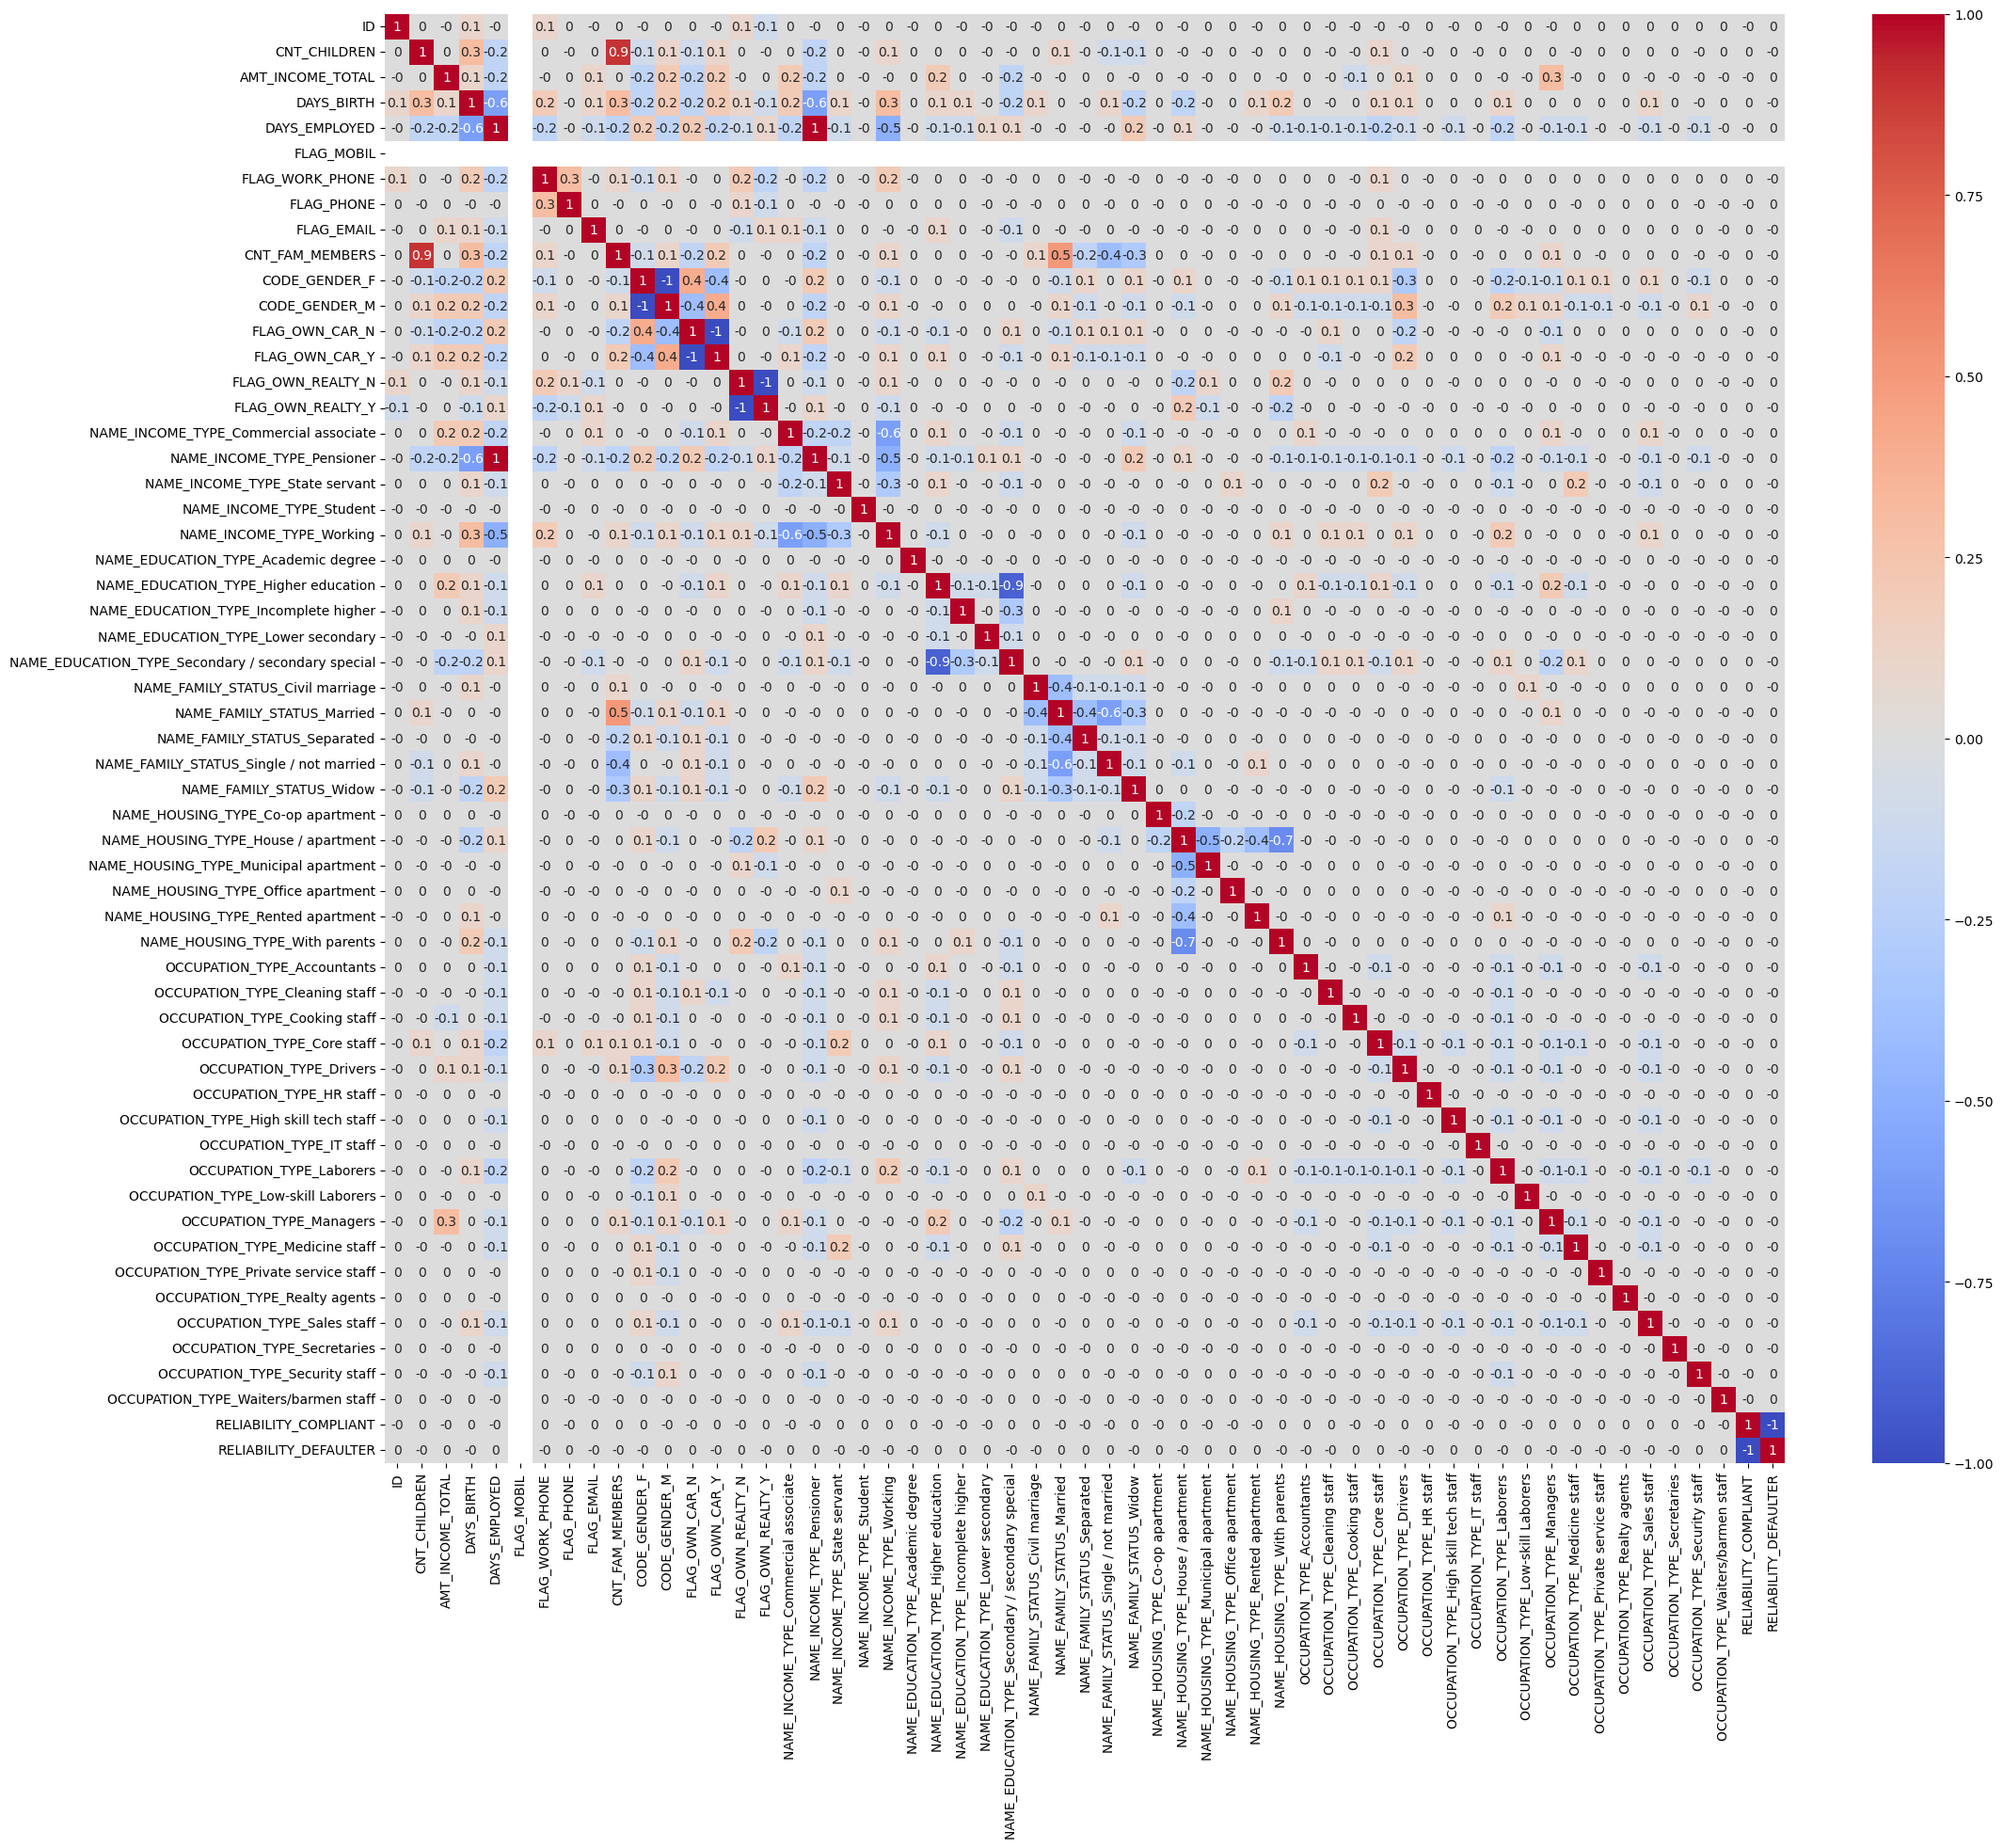

In [39]:
# Select categorical features
categorical_columns = df_application_reliability.select_dtypes(exclude = ["number"]).columns.tolist()

# Encode categorical features
df_corr = pd.get_dummies(df_application_reliability, columns = categorical_columns)

# Evaluate correlation
correlation_matrix = df_corr.corr(numeric_only = True)

# Store correlation matrix
correlation_matrix.to_csv("Analysis/correlation_matrix_application_reliability.csv")

# Plot correlation matrix
plt.figure(figsize = (24, 20))
sns.heatmap(round(correlation_matrix, 1), annot = True, cmap = "coolwarm")
plt.show()

The correlation matrix does not highlight significant correlations between the features and the target variable, suggesting that any potential relationship with the target might be determined by a more complex combination of features.

Regarding the correlations between features, here are some observed relationships:

- CNT_CHILDREN: The number of children is naturally positively correlated with the family size (CNT_FAM_MEMBERS) and appears to be slightly correlated with age (DAYS_BIRTH), negatively as the latter takes negative values representing the distance from the day of birth.
- AMT_INCOME_TOTAL: Annual earnings are slightly positively correlated with the occupational position (OCCUPATION_TYPE) being a Manager.
- DAYS_BIRTH: Age is moderately correlated with days employed (DAYS_EMPLOYED) and with income type (NAME_INCOME_TYPE) being a Pensioner.
- DAYS_EMPLOYED: Days employed are naturally correlated with income from working (NAME_INCOME_TYPE_Working) and are entirely correlated with income from a pension (NAME_INCOME_TYPE_Pensioner), as in that case, they are set to a fixed placholder value of 365243 days (1000 years).
- CNT_FAM_MEMBERS: Family size is moderately correlated with family status being Married (NAME_FAMILY_STATUS).
- CODE_GENDER: for both male and female genders there is correlation with having an own car (FLAG_OWN_CAR).

In [40]:
# FLAG_MOBIL is not shown since it is the same for all clients
df_application_reliability['FLAG_MOBIL'].value_counts()

1    33110
Name: FLAG_MOBIL, dtype: int64

In [41]:
# Store correlation matrix
round(correlation_matrix, 1).to_csv("Analysis/correlation_matrix_application_reliability.csv")

## Preprocessing

In [42]:
# Preserve the original dataset
df_preproc = df_application_reliability.copy()

#### Removal of Unuseful Features

In [43]:
print("Number of unique values for each variable:")
for column in df_preproc.columns:
    print(f"- {column}: {len(df_preproc[column].unique())}")

Number of unique values for each variable:
- ID: 33110
- CODE_GENDER: 2
- FLAG_OWN_CAR: 2
- FLAG_OWN_REALTY: 2
- CNT_CHILDREN: 9
- AMT_INCOME_TOTAL: 258
- NAME_INCOME_TYPE: 5
- NAME_EDUCATION_TYPE: 5
- NAME_FAMILY_STATUS: 5
- NAME_HOUSING_TYPE: 6
- DAYS_BIRTH: 6960
- DAYS_EMPLOYED: 3566
- FLAG_MOBIL: 1
- FLAG_WORK_PHONE: 2
- FLAG_PHONE: 2
- FLAG_EMAIL: 2
- OCCUPATION_TYPE: 19
- CNT_FAM_MEMBERS: 10
- RELIABILITY: 2


As already verified previously, the ID feature is present with all singular occurences, so as customer identifier is not offering any information and can be removed. Opposite case for FLAG_MOBIL that is the same for all observations, so unuseful as well.

In [44]:
# Remove "ID" column
df_preproc.drop('ID', axis = 1, inplace = True)

In [45]:
# Remove "FLAG_MOBIL" column
df_preproc.drop('FLAG_MOBIL', axis = 1, inplace = True)

#### Missing Data Verification

In [46]:
# Sum of not available value for each column
df_preproc.isna().sum()

CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        10373
CNT_FAM_MEMBERS            0
RELIABILITY                0
dtype: int64

Since the missing values for OCCUPATION_TYPE account for about one-third of the total data, removing all affected observations would result in a significant loss of information. Considering that OCCUPATION_TYPE is a categorical feature, one option is to impute the most frequent value or to analyze whether the absence of the value is correlated with any other features. To do this, the missing values can be replaced with a flag placeholder, and the correlation for this class with all other features can be re-evaluated.

In [47]:
# Fill missing values with placeholder undefined class
NA_PLACEHOLDER = "Undefined"
df_preproc['OCCUPATION_TYPE'] = df_preproc['OCCUPATION_TYPE'].fillna(NA_PLACEHOLDER)

In [48]:
# Number of occurrences for each class in OCCUPATION_TYPE feature
df_preproc['OCCUPATION_TYPE'].value_counts()

Undefined                10373
Laborers                  5601
Core staff                3250
Sales staff               3156
Managers                  2695
Drivers                   1934
High skill tech staff     1269
Medicine staff            1124
Accountants               1106
Cooking staff              587
Security staff             547
Cleaning staff             511
Private service staff      293
Waiters/barmen staff       163
Low-skill Laborers         159
Secretaries                142
HR staff                    76
Realty agents               67
IT staff                    57
Name: OCCUPATION_TYPE, dtype: int64

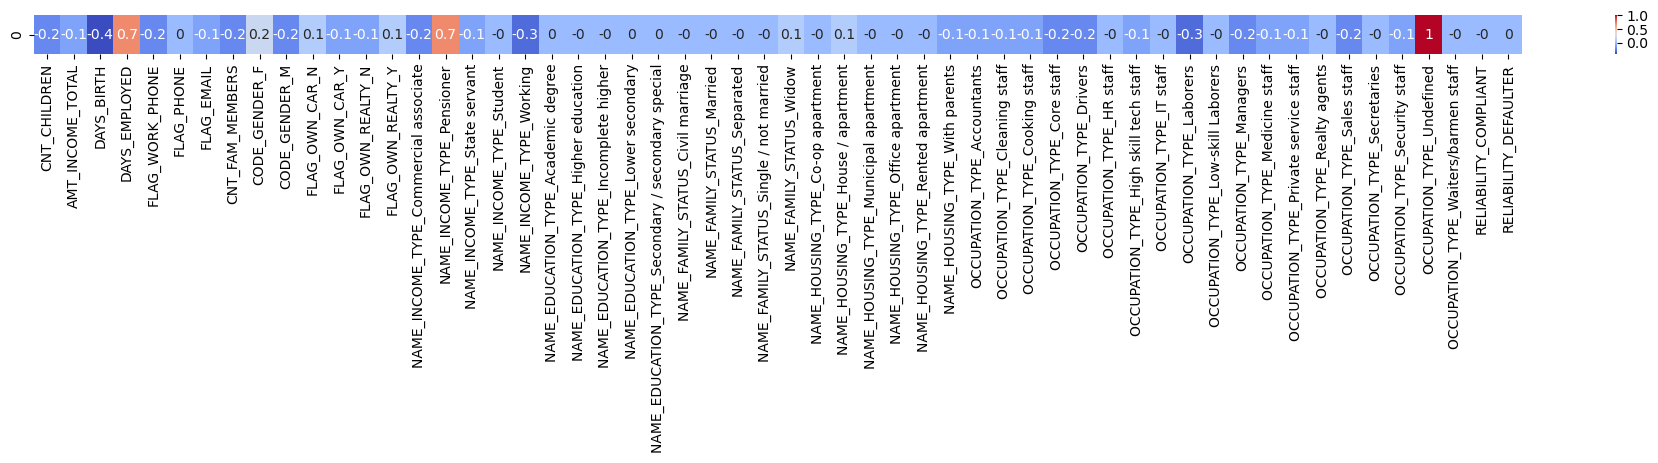

In [49]:
# Select categorical features
categorical_columns = df_preproc.select_dtypes(exclude = ["number"]).columns.tolist()

# Encode categorical features
df_corr = pd.get_dummies(df_preproc, columns = categorical_columns)

# Evaluate correlation
correlation_matrix = df_corr.corrwith(df_corr['OCCUPATION_TYPE' + '_' + NA_PLACEHOLDER]).to_frame().T

# Plot correlation matrix
plt.figure(figsize = (24, 0.5))
sns.heatmap(round(correlation_matrix, 1), annot = True, cmap = "coolwarm")
plt.show()

From the total number of occurrences for each OCCUPATION_TYPE class, there doesn't seem to be a predominant class worth imputing for the missing values.

The correlation between missing values and other features shows that undefined occupation is strongly associated with pension income, possibly indicating that this data was not entered for many of those cases.

As no additional information emerges on how to appropriately impute this missing data, it is preferable to retain the placeholder for undefined occupation to avoid potentially biasing the subsequent model construction.

#### Features Encoding

Subsequently, all categorical features will be encoded using binary encoding or split using one-hot encoding.

In [50]:
# Check all unique different values for categorical features
non_numeric_columns = df_preproc.select_dtypes(exclude = ["number"]).columns.tolist()

print("# Unique values for categorical features #")
for column in non_numeric_columns:
    print(f"\n{column}:")
    value_counts = df_preproc[column].value_counts()
    for value, count in value_counts.items():
        print(f"- {value}: {count}")

# Unique values for categorical features #

CODE_GENDER:
- F: 22220
- M: 10890

FLAG_OWN_CAR:
- N: 20618
- Y: 12492

FLAG_OWN_REALTY:
- Y: 22288
- N: 10822

NAME_INCOME_TYPE:
- Working: 17077
- Commercial associate: 7627
- Pensioner: 5659
- State servant: 2736
- Student: 11

NAME_EDUCATION_TYPE:
- Secondary / secondary special: 22554
- Higher education: 8891
- Incomplete higher: 1292
- Lower secondary: 344
- Academic degree: 29

NAME_FAMILY_STATUS:
- Married: 22725
- Single / not married: 4433
- Civil marriage: 2656
- Separated: 1908
- Widow: 1388

NAME_HOUSING_TYPE:
- House / apartment: 29579
- With parents: 1598
- Municipal apartment: 1015
- Rented apartment: 536
- Office apartment: 242
- Co-op apartment: 140

OCCUPATION_TYPE:
- Undefined: 10373
- Laborers: 5601
- Core staff: 3250
- Sales staff: 3156
- Managers: 2695
- Drivers: 1934
- High skill tech staff: 1269
- Medicine staff: 1124
- Accountants: 1106
- Cooking staff: 587
- Security staff: 547
- Cleaning staff: 511
- Private servi

#### Binary Encoding

In [51]:
# CODE_GENDER Encoding
mapping_gender = {
    "M" : 0,
    "F" : 1
}

df_preproc['CODE_GENDER'] = df_preproc['CODE_GENDER'].map(mapping_gender)

In [52]:
# FLAG_OWN_CAR Encoding
mapping_own_car = {
    "N" : 0,
    "Y" : 1
}

df_preproc['FLAG_OWN_CAR'] = df_preproc['FLAG_OWN_CAR'].map(mapping_own_car)

In [53]:
# FLAG_OWN_REALTY Encoding
mapping_own_realty = {
    "N" : 0,
    "Y" : 1
}

df_preproc['FLAG_OWN_REALTY'] = df_preproc['FLAG_OWN_REALTY'].map(mapping_own_realty)

#### One-Hot Encoding

In [54]:
# One-Hot Encoding
df_preproc = pd.get_dummies(df_preproc, columns = ['NAME_INCOME_TYPE'])
df_preproc = pd.get_dummies(df_preproc, columns = ['NAME_EDUCATION_TYPE'])
df_preproc = pd.get_dummies(df_preproc, columns = ['NAME_FAMILY_STATUS'])
df_preproc = pd.get_dummies(df_preproc, columns = ['NAME_HOUSING_TYPE'])
df_preproc = pd.get_dummies(df_preproc, columns = ['OCCUPATION_TYPE'])

#### Target Encoding

In [55]:
# CODE_GENDER Encoding
mapping_reliability = {
    "COMPLIANT" : 0,
    "DEFAULTER" : 1
}

df_preproc['RELIABILITY'] = df_preproc['RELIABILITY'].map(mapping_reliability)

In [56]:
df_preproc.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,...,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Undefined,OCCUPATION_TYPE_Waiters/barmen staff
0,0,1,1,0,427500.0,-12005,-4542,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,1,0,427500.0,-12005,-4542,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1,1,0,112500.0,-21474,-1134,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,1,0,270000.0,-19110,-3051,0,1,1,...,0,0,0,0,0,1,0,0,0,0
5,1,0,1,0,270000.0,-19110,-3051,0,1,1,...,0,0,0,0,0,1,0,0,0,0


In [57]:
# Store preprocessed dataset
df_preproc.to_csv("Datasets/preprocessed_application_reliability.csv")

#### Features and Target Selection

In [58]:
# Select all features
X = df_preproc.copy()
X = X.drop('RELIABILITY', axis = 1).values

# Select the target
y = df_preproc.copy()
y = y['RELIABILITY'].values

## Model 0 - Hold-Out Validation - Baseline

As a first step, a baseline model is constructed using a simple logistic regression. This model is validated using a dataset split into training and test sets, maintaining class proportionality between them. The training set is used to train the model, while the test set is reserved to evaluate the model's performance on new data.

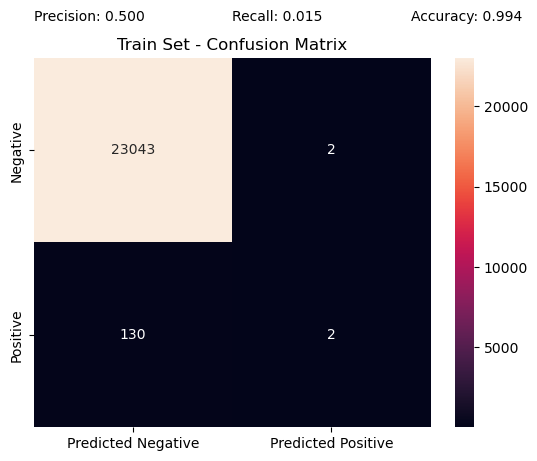

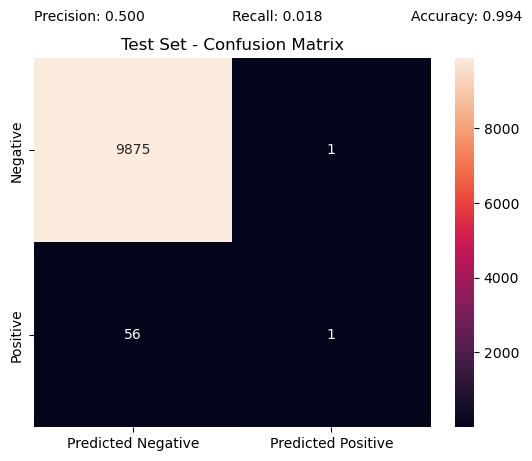

LogisticRegression()

In [59]:
generate_logistic_regressor(X, y,
                            test_size = 0.3,
                            random_state = RANDOM_SEED,
                            model_name = "M0_LogRegr_Baseline",
                            show_confusion_matrix = True)

## Model 1 - Hold-Out Validation with Class Balanced

Given the baseline model with almost null recall, characterized by a totality of false negatives, an attempt to enhance performance involves implementing a logistic regression model with balanced class weights. As noticed during the features enconding phase, classes distribution for some variables (included the target) have an heterogeneous numerosity.

The emphasis is placed on recall as it is deemed crucial to identify the highest number of potentially risky customers, even at the expense of excluding reliable ones. The rationale behind this preference is that the potential loss of financial value from an unpaid debt is considered more detrimental than forgoing interest earnings from credit card usage for reliable customers excluded from this opportunity.

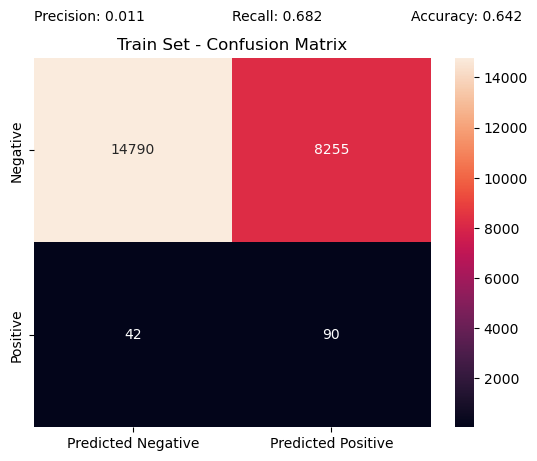

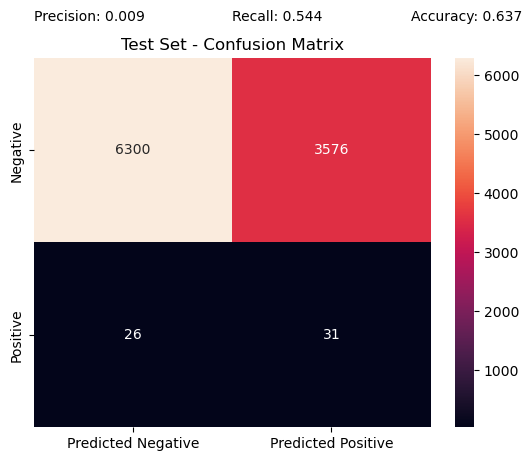

LogisticRegression(class_weight='balanced')

In [60]:
generate_logistic_regressor(X, y,
                            test_size = 0.3,
                            class_weight = 'balanced',
                            random_state = RANDOM_SEED,
                            model_name = "M1_LogRegr_ClassBalance",
                            show_confusion_matrix = True)

## Models Comparison

In [61]:
print("Train Models - Metrics Comparison")
round(df_metrics_train, 2)

Train Models - Metrics Comparison


,Model,Precision,Recall,Accuracy,F1,Log Loss
0,M0_LogRegr_Baseline,0.50,0.02,0.99,0.03,0.03
1,M1_LogRegr_ClassBalance,0.01,0.68,0.64,0.02,0.61


In [62]:
print("Train Models - Metrics Comparison")
round(df_metrics_test, 2)

Train Models - Metrics Comparison


,Model,Precision,Recall,Accuracy,F1,Log Loss
0,M0_LogRegr_Baseline,0.50,0.02,0.99,0.03,0.04
1,M1_LogRegr_ClassBalance,0.01,0.54,0.64,0.02,0.61


From an initial comparison, given the not-so-high performance, it appears that using a basic logistic regressor is a starting point that can be improved, even when considering class balancing.

## Model 2 - Stochastic Gradient Descent Classifier

Now, an exploration will be conducted using a more sophisticated model, specifically the stochastic gradient descent classifier. The model will be initially tested in full batch mode with its basic configuration, along with variations involving undersampling and oversampling. Following this, the model exhibiting superior performance will be fine-tuned by using different batch sizes to identify the optimal one.


### Stochastic Gradient Descent Classifier ###

Batch size: 23177
Log loss at epoch 1 = 0.21	(best loss: 0.21)
Log loss at epoch 2 = 0.21	(best loss: 0.21)
Log loss at epoch 3 = 0.21	(best loss: 0.21)
Log loss at epoch 4 = 0.21	(best loss: 0.21)
Log loss at epoch 5 = 0.21	(best loss: 0.21)
Log loss at epoch 6 = 0.21	(best loss: 0.21)
Log loss at epoch 7 = 0.21	(best loss: 0.21)
Log loss at epoch 8 = 0.21	(best loss: 0.21)
Log loss at epoch 9 = 0.22	(best loss: 0.21)
Log loss at epoch 10 = 0.22	(best loss: 0.21)
Log loss at epoch 11 = 0.21	(best loss: 0.21)
Log loss at epoch 12 = 0.22	(best loss: 0.21)
Log loss at epoch 13 = 0.22	(best loss: 0.21)
Early Stopping!


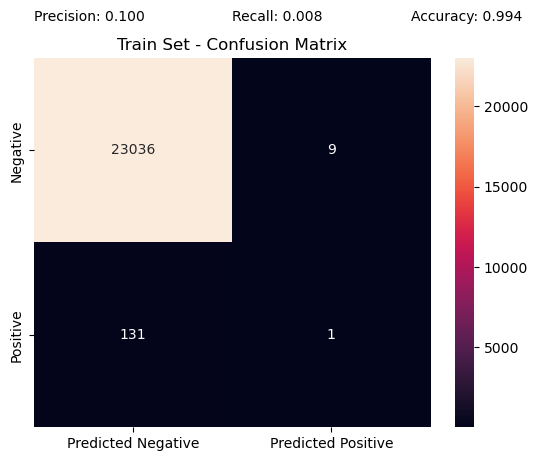

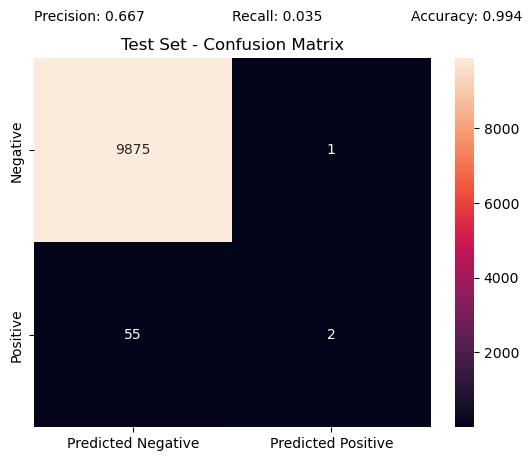

Training completed in 0.49 seconds


[SGDClassifier(loss='log_loss', random_state=0)]

In [63]:
generate_SGD_classifier(X, y,
                        test_size = 0.3,
                        batch_sizes = 'full_batch',
                        random_state = RANDOM_SEED,
                        model_name = "M2.1_SGD_FullBatch",
                        show_confusion_matrix = True)


### Stochastic Gradient Descent Classifier ###

Batch size: 264
Log loss at epoch 1 = 15.56	(best loss: 15.56)
Log loss at epoch 2 = 15.43	(best loss: 15.43)
Log loss at epoch 3 = 15.43	(best loss: 15.43)
Log loss at epoch 4 = 14.88	(best loss: 14.88)
Log loss at epoch 5 = 14.61	(best loss: 14.61)
Log loss at epoch 6 = 15.70	(best loss: 14.61)
Log loss at epoch 7 = 15.43	(best loss: 14.61)
Log loss at epoch 8 = 14.88	(best loss: 14.61)
Log loss at epoch 9 = 15.02	(best loss: 14.61)
Log loss at epoch 10 = 15.29	(best loss: 14.61)
Log loss at epoch 11 = 15.84	(best loss: 14.61)
Log loss at epoch 12 = 15.02	(best loss: 14.61)
Log loss at epoch 13 = 15.02	(best loss: 14.61)
Log loss at epoch 14 = 15.15	(best loss: 14.61)
Log loss at epoch 15 = 15.15	(best loss: 14.61)
Early Stopping!


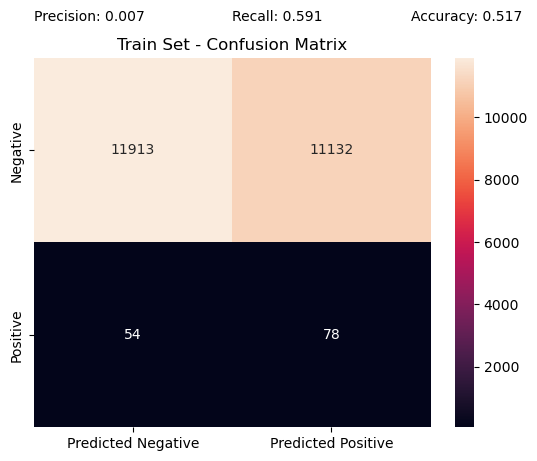

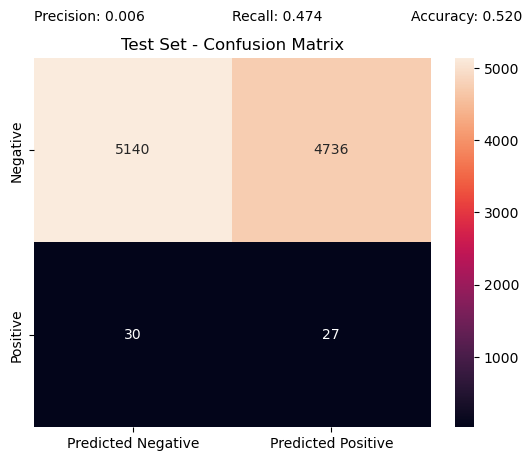

Training completed in 0.34 seconds


[SGDClassifier(loss='log_loss', random_state=0)]

In [64]:
generate_SGD_classifier(X, y,
                        test_size = 0.3,
                        batch_sizes = 'full_batch',
                        sampler = 'RandomUnderSampler',
                        sampling_strategy = 'not minority',
                        random_state = RANDOM_SEED,
                        model_name = "M2.2_SGD_FullBatch_UnderSample",
                        show_confusion_matrix = True)


### Stochastic Gradient Descent Classifier ###

Batch size: 46090
Log loss at epoch 1 = 16.46	(best loss: 16.46)
Log loss at epoch 2 = 15.75	(best loss: 15.75)
Log loss at epoch 3 = 15.41	(best loss: 15.41)
Log loss at epoch 4 = 14.65	(best loss: 14.65)
Log loss at epoch 5 = 14.06	(best loss: 14.06)
Log loss at epoch 6 = 12.98	(best loss: 12.98)
Log loss at epoch 7 = 12.42	(best loss: 12.42)
Log loss at epoch 8 = 12.79	(best loss: 12.42)
Log loss at epoch 9 = 12.87	(best loss: 12.42)
Log loss at epoch 10 = 12.79	(best loss: 12.42)
Log loss at epoch 11 = 12.75	(best loss: 12.42)
Log loss at epoch 12 = 12.86	(best loss: 12.42)
Log loss at epoch 13 = 12.84	(best loss: 12.42)
Log loss at epoch 14 = 12.83	(best loss: 12.42)
Log loss at epoch 15 = 12.68	(best loss: 12.42)
Log loss at epoch 16 = 12.55	(best loss: 12.42)
Log loss at epoch 17 = 12.53	(best loss: 12.42)
Early Stopping!


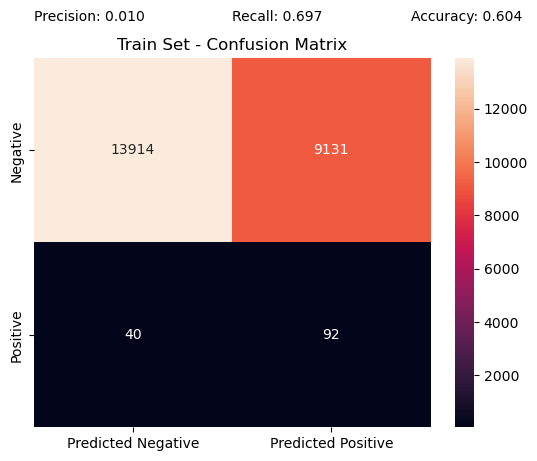

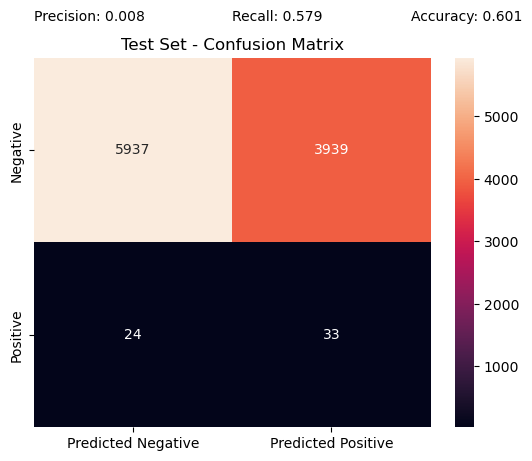

Training completed in 0.87 seconds


[SGDClassifier(loss='log_loss', random_state=0)]

In [65]:
generate_SGD_classifier(X, y,
                        test_size = 0.3,
                        batch_sizes = 'full_batch',
                        sampler = 'RandomOverSampler',
                        sampling_strategy = 'not majority',
                        random_state = RANDOM_SEED,
                        model_name = "M2.3_SGD_FullBatch_OverSample",
                        show_confusion_matrix = True)

## Models Comparison

In [66]:
print("Train Models - Metrics Comparison")
round(df_metrics_train, 2)

Train Models - Metrics Comparison


,Model,Precision,Recall,Accuracy,F1,Log Loss
0,M0_LogRegr_Baseline,0.50,0.02,0.99,0.03,0.03
1,M1_LogRegr_ClassBalance,0.01,0.68,0.64,0.02,0.61
2,M2.1_SGD_FullBatch_BatchSize-23177,0.10,0.01,0.99,0.01,0.11
3,M2.2_SGD_FullBatch_UnderSample_BatchSize-264,0.01,0.59,0.52,0.01,12.70
4,M2.3_SGD_FullBatch_OverSample_BatchSize-46090,0.01,0.70,0.60,0.02,0.67


In [67]:
print("Train Models - Metrics Comparison")
round(df_metrics_test, 2)

Train Models - Metrics Comparison


,Model,Precision,Recall,Accuracy,F1,Log Loss
0,M0_LogRegr_Baseline,0.50,0.02,0.99,0.03,0.04
1,M1_LogRegr_ClassBalance,0.01,0.54,0.64,0.02,0.61
2,M2.1_SGD_FullBatch_BatchSize-23177,0.67,0.04,0.99,0.07,0.14
3,M2.2_SGD_FullBatch_UnderSample_BatchSize-264,0.01,0.47,0.52,0.01,12.64
4,M2.3_SGD_FullBatch_OverSample_BatchSize-46090,0.01,0.58,0.60,0.02,0.68


#### Best SGD Model for Different Batch Sizes

The oversampling model, which duplicates all minority classes, shows the highest recall compared to the previous models, albeit with lower accuracy than the base SGD model. Therefore, the oversampling model will be tested using different batch sizes to explore potential improvements in overall performance.


### Stochastic Gradient Descent Classifier ###

Batch size: 8
Log loss at epoch 1 = 14.57	(best loss: 14.57)
Log loss at epoch 2 = 14.52	(best loss: 14.52)
Log loss at epoch 3 = 14.29	(best loss: 14.29)
Log loss at epoch 4 = 14.39	(best loss: 14.29)
Log loss at epoch 5 = 14.16	(best loss: 14.16)
Log loss at epoch 6 = 13.98	(best loss: 13.98)
Log loss at epoch 7 = 13.53	(best loss: 13.53)
Log loss at epoch 8 = 13.42	(best loss: 13.42)
Log loss at epoch 9 = 13.45	(best loss: 13.42)
Log loss at epoch 10 = 13.55	(best loss: 13.42)
Log loss at epoch 11 = 13.59	(best loss: 13.42)
Log loss at epoch 12 = 13.31	(best loss: 13.31)
Log loss at epoch 13 = 13.33	(best loss: 13.31)
Log loss at epoch 14 = 13.31	(best loss: 13.31)
Log loss at epoch 15 = 13.14	(best loss: 13.14)
Log loss at epoch 16 = 13.10	(best loss: 13.10)
Log loss at epoch 17 = 13.11	(best loss: 13.10)
Log loss at epoch 18 = 13.10	(best loss: 13.10)
Log loss at epoch 19 = 12.94	(best loss: 12.94)
Log loss at epoch 20 = 12.77	(best

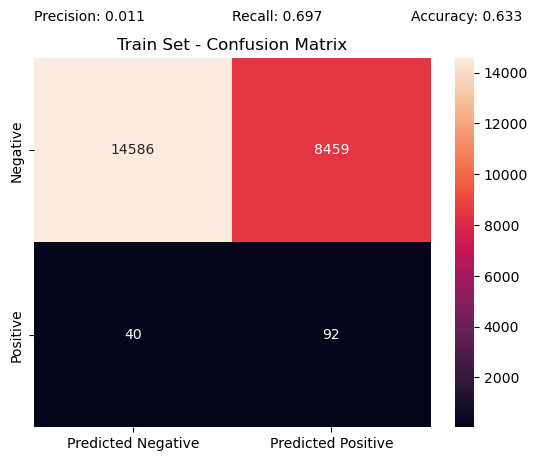

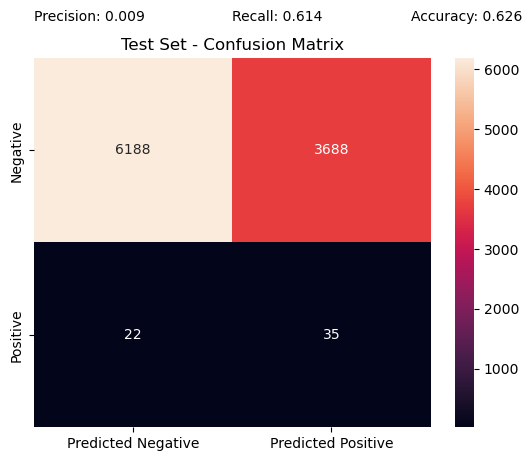

Training completed in 1990.48 seconds

Batch size: 16
Log loss at epoch 1 = 15.87	(best loss: 15.87)
Log loss at epoch 2 = 15.30	(best loss: 15.30)
Log loss at epoch 3 = 14.79	(best loss: 14.79)
Log loss at epoch 4 = 14.57	(best loss: 14.57)
Log loss at epoch 5 = 13.60	(best loss: 13.60)
Log loss at epoch 6 = 13.69	(best loss: 13.60)
Log loss at epoch 7 = 13.79	(best loss: 13.60)
Log loss at epoch 8 = 13.59	(best loss: 13.59)
Log loss at epoch 9 = 13.31	(best loss: 13.31)
Log loss at epoch 10 = 13.07	(best loss: 13.07)
Log loss at epoch 11 = 13.20	(best loss: 13.07)
Log loss at epoch 12 = 13.20	(best loss: 13.07)
Log loss at epoch 13 = 13.20	(best loss: 13.07)
Log loss at epoch 14 = 13.19	(best loss: 13.07)
Log loss at epoch 15 = 13.32	(best loss: 13.07)
Log loss at epoch 16 = 13.31	(best loss: 13.07)
Log loss at epoch 17 = 13.11	(best loss: 13.07)
Log loss at epoch 18 = 13.10	(best loss: 13.07)
Log loss at epoch 19 = 13.05	(best loss: 13.05)
Log loss at epoch 20 = 12.73	(best loss: 12

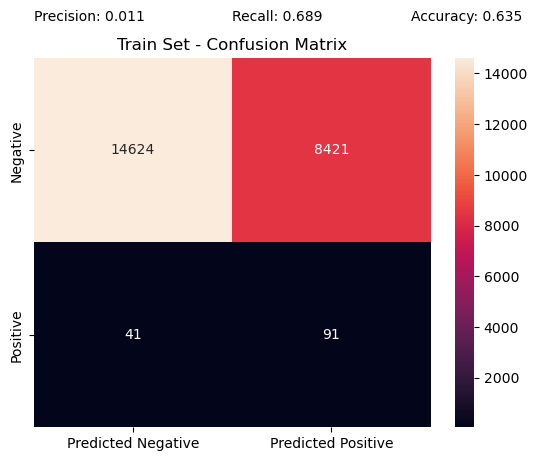

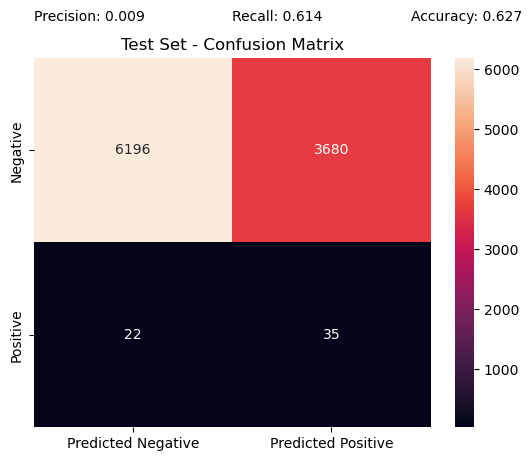

Training completed in 2857.61 seconds

Batch size: 32
Log loss at epoch 1 = 14.98	(best loss: 14.98)
Log loss at epoch 2 = 15.06	(best loss: 14.98)
Log loss at epoch 3 = 15.19	(best loss: 14.98)
Log loss at epoch 4 = 15.23	(best loss: 14.98)
Log loss at epoch 5 = 14.76	(best loss: 14.76)
Log loss at epoch 6 = 14.54	(best loss: 14.54)
Log loss at epoch 7 = 13.71	(best loss: 13.71)
Log loss at epoch 8 = 13.92	(best loss: 13.71)
Log loss at epoch 9 = 13.42	(best loss: 13.42)
Log loss at epoch 10 = 12.89	(best loss: 12.89)
Log loss at epoch 11 = 13.37	(best loss: 12.89)
Log loss at epoch 12 = 13.34	(best loss: 12.89)
Log loss at epoch 13 = 13.29	(best loss: 12.89)
Log loss at epoch 14 = 13.28	(best loss: 12.89)
Log loss at epoch 15 = 13.25	(best loss: 12.89)
Log loss at epoch 16 = 13.31	(best loss: 12.89)
Log loss at epoch 17 = 13.16	(best loss: 12.89)
Log loss at epoch 18 = 13.17	(best loss: 12.89)
Log loss at epoch 19 = 13.13	(best loss: 12.89)
Log loss at epoch 20 = 12.94	(best loss: 12

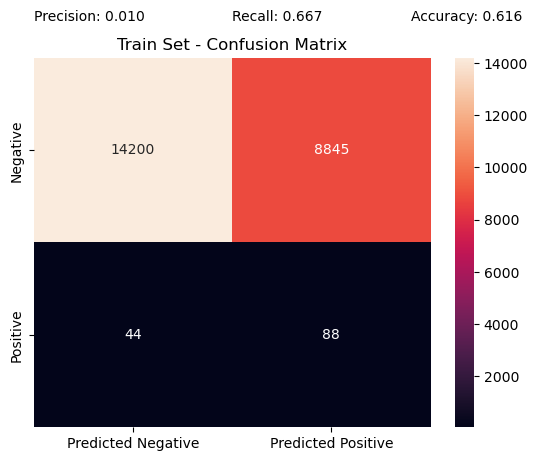

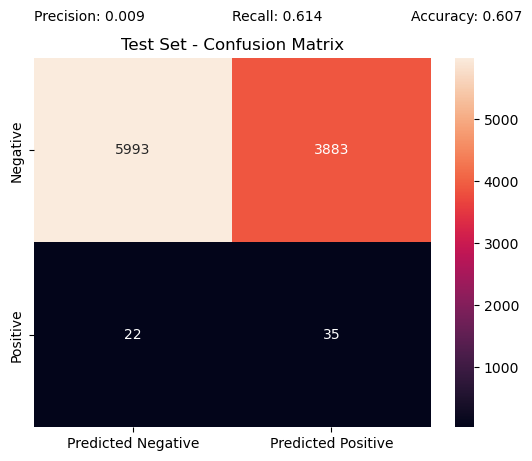

Training completed in 3047.52 seconds

Batch size: 64
Log loss at epoch 1 = 14.49	(best loss: 14.49)
Log loss at epoch 2 = 14.18	(best loss: 14.18)
Log loss at epoch 3 = 14.32	(best loss: 14.18)
Log loss at epoch 4 = 14.26	(best loss: 14.18)
Log loss at epoch 5 = 13.93	(best loss: 13.93)
Log loss at epoch 6 = 14.06	(best loss: 13.93)
Log loss at epoch 7 = 13.75	(best loss: 13.75)
Log loss at epoch 8 = 13.80	(best loss: 13.75)
Log loss at epoch 9 = 13.04	(best loss: 13.04)
Log loss at epoch 10 = 12.80	(best loss: 12.80)
Log loss at epoch 11 = 13.24	(best loss: 12.80)
Log loss at epoch 12 = 13.13	(best loss: 12.80)
Log loss at epoch 13 = 13.02	(best loss: 12.80)
Log loss at epoch 14 = 13.01	(best loss: 12.80)
Log loss at epoch 15 = 13.00	(best loss: 12.80)
Log loss at epoch 16 = 12.83	(best loss: 12.80)
Log loss at epoch 17 = 12.84	(best loss: 12.80)
Log loss at epoch 18 = 12.85	(best loss: 12.80)
Log loss at epoch 19 = 12.81	(best loss: 12.80)
Log loss at epoch 20 = 12.80	(best loss: 12

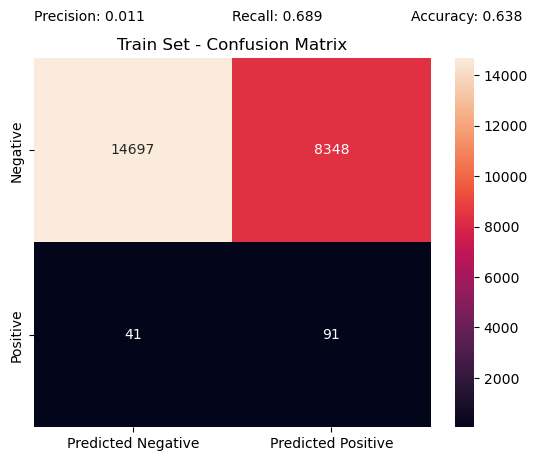

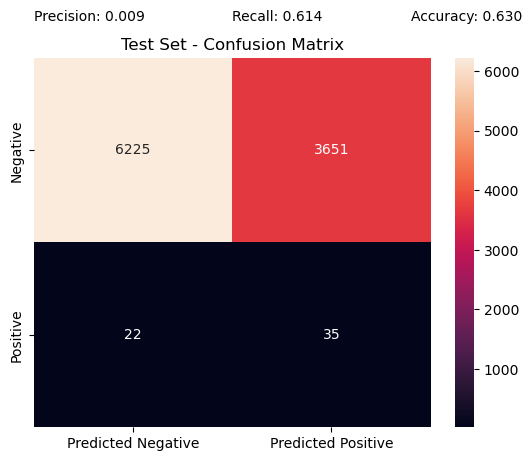

Training completed in 3252.03 seconds

Batch size: 128
Log loss at epoch 1 = 15.32	(best loss: 15.32)
Log loss at epoch 2 = 15.24	(best loss: 15.24)
Log loss at epoch 3 = 15.11	(best loss: 15.11)
Log loss at epoch 4 = 14.39	(best loss: 14.39)
Log loss at epoch 5 = 14.24	(best loss: 14.24)
Log loss at epoch 6 = 13.34	(best loss: 13.34)
Log loss at epoch 7 = 13.33	(best loss: 13.33)
Log loss at epoch 8 = 13.31	(best loss: 13.31)
Log loss at epoch 9 = 12.90	(best loss: 12.90)
Log loss at epoch 10 = 12.84	(best loss: 12.84)
Log loss at epoch 11 = 12.69	(best loss: 12.69)
Log loss at epoch 12 = 12.79	(best loss: 12.69)
Log loss at epoch 13 = 13.04	(best loss: 12.69)
Log loss at epoch 14 = 13.03	(best loss: 12.69)
Log loss at epoch 15 = 13.07	(best loss: 12.69)
Log loss at epoch 16 = 13.17	(best loss: 12.69)
Log loss at epoch 17 = 12.99	(best loss: 12.69)
Log loss at epoch 18 = 12.98	(best loss: 12.69)
Log loss at epoch 19 = 12.80	(best loss: 12.69)
Log loss at epoch 20 = 12.64	(best loss: 1

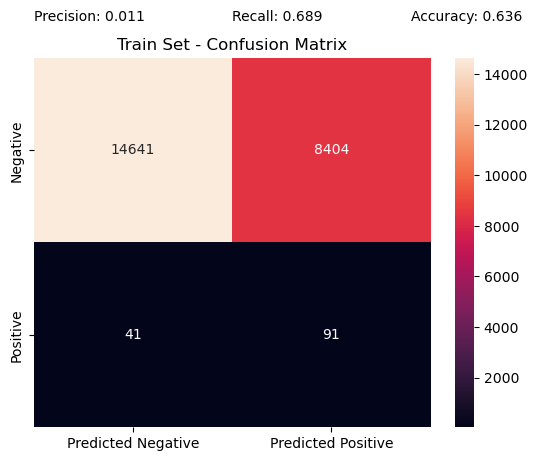

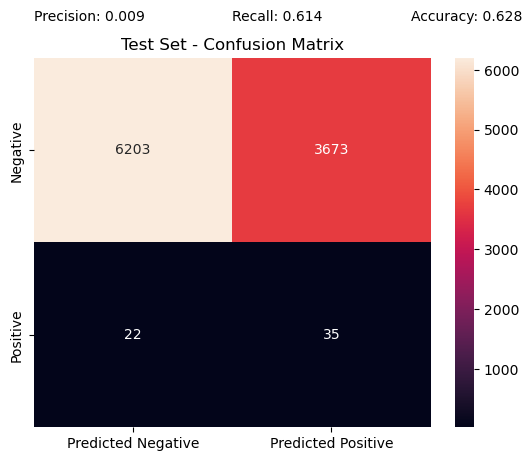

Training completed in 3331.99 seconds

Batch size: 256
Log loss at epoch 1 = 14.00	(best loss: 14.00)
Log loss at epoch 2 = 14.29	(best loss: 14.00)
Log loss at epoch 3 = 13.81	(best loss: 13.81)
Log loss at epoch 4 = 13.56	(best loss: 13.56)
Log loss at epoch 5 = 13.11	(best loss: 13.11)
Log loss at epoch 6 = 12.70	(best loss: 12.70)
Log loss at epoch 7 = 12.64	(best loss: 12.64)
Log loss at epoch 8 = 12.45	(best loss: 12.45)
Log loss at epoch 9 = 12.55	(best loss: 12.45)
Log loss at epoch 10 = 12.51	(best loss: 12.45)
Log loss at epoch 11 = 12.64	(best loss: 12.45)
Log loss at epoch 12 = 12.62	(best loss: 12.45)
Log loss at epoch 13 = 12.63	(best loss: 12.45)
Log loss at epoch 14 = 12.63	(best loss: 12.45)
Log loss at epoch 15 = 12.76	(best loss: 12.45)
Log loss at epoch 16 = 12.76	(best loss: 12.45)
Log loss at epoch 17 = 12.77	(best loss: 12.45)
Log loss at epoch 18 = 12.79	(best loss: 12.45)
Early Stopping!


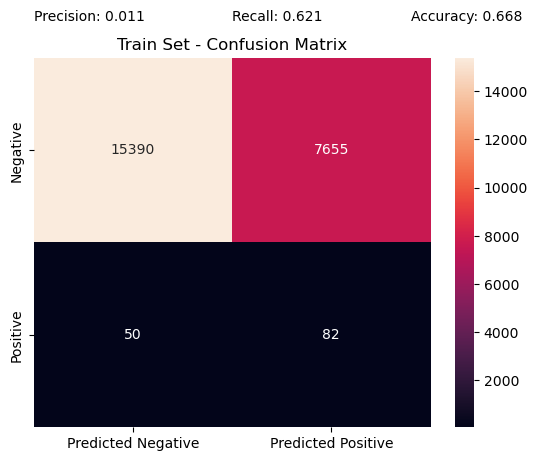

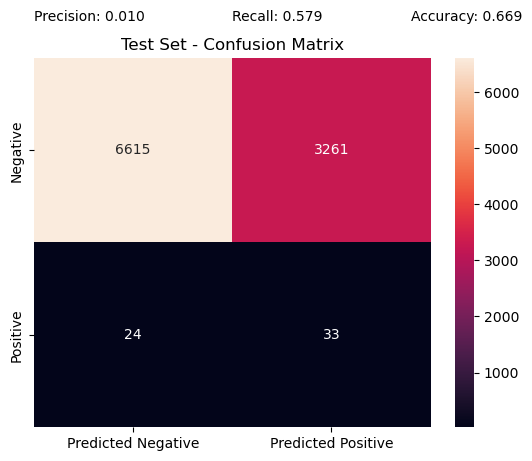

Training completed in 3354.36 seconds

Batch size: 512
Log loss at epoch 1 = 13.90	(best loss: 13.90)
Log loss at epoch 2 = 13.55	(best loss: 13.55)
Log loss at epoch 3 = 13.49	(best loss: 13.49)
Log loss at epoch 4 = 13.25	(best loss: 13.25)
Log loss at epoch 5 = 13.04	(best loss: 13.04)
Log loss at epoch 6 = 12.91	(best loss: 12.91)
Log loss at epoch 7 = 12.57	(best loss: 12.57)
Log loss at epoch 8 = 12.25	(best loss: 12.25)
Log loss at epoch 9 = 12.30	(best loss: 12.25)
Log loss at epoch 10 = 12.21	(best loss: 12.21)
Log loss at epoch 11 = 12.29	(best loss: 12.21)
Log loss at epoch 12 = 12.34	(best loss: 12.21)
Log loss at epoch 13 = 12.12	(best loss: 12.12)
Log loss at epoch 14 = 11.89	(best loss: 11.89)
Log loss at epoch 15 = 11.84	(best loss: 11.84)
Log loss at epoch 16 = 11.75	(best loss: 11.75)
Log loss at epoch 17 = 11.52	(best loss: 11.52)
Log loss at epoch 18 = 11.44	(best loss: 11.44)
Log loss at epoch 19 = 11.56	(best loss: 11.44)
Log loss at epoch 20 = 11.62	(best loss: 1

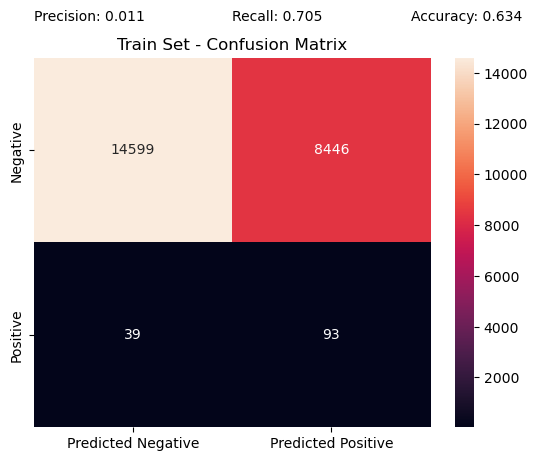

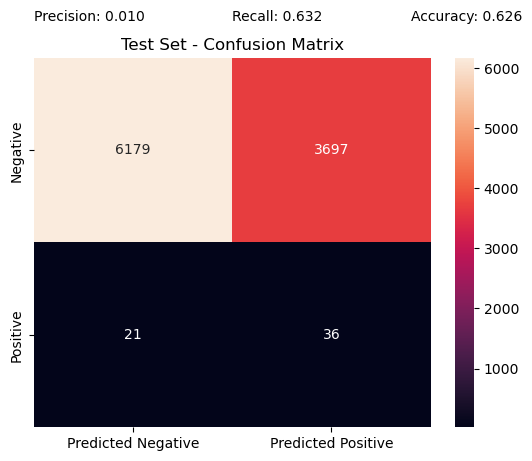

Training completed in 3371.82 seconds


[SGDClassifier(loss='log_loss', random_state=0),
 SGDClassifier(loss='log_loss', random_state=0),
 SGDClassifier(loss='log_loss', random_state=0),
 SGDClassifier(loss='log_loss', random_state=0),
 SGDClassifier(loss='log_loss', random_state=0),
 SGDClassifier(loss='log_loss', random_state=0),
 SGDClassifier(loss='log_loss', random_state=0)]

In [68]:
generate_SGD_classifier(X, y,
                        test_size = 0.3,
                        batch_sizes = [8, 16, 32, 64, 128, 256, 512],
                        sampler = 'RandomOverSampler',
                        sampling_strategy = 'not majority',
                        random_state = RANDOM_SEED,
                        model_name = "M2.4_SGD_OverSample",
                        show_confusion_matrix = True)

## Models Comparison

In [69]:
print("Train Models - Metrics Comparison")
round(df_metrics_train, 2)

Train Models - Metrics Comparison


,Model,Precision,Recall,Accuracy,F1,Log Loss
0,M0_LogRegr_Baseline,0.50,0.02,0.99,0.03,0.03
1,M1_LogRegr_ClassBalance,0.01,0.68,0.64,0.02,0.61
2,M2.1_SGD_FullBatch_BatchSize-23177,0.10,0.01,0.99,0.01,0.11
3,M2.2_SGD_FullBatch_UnderSample_BatchSize-264,0.01,0.59,0.52,0.01,12.70
4,M2.3_SGD_FullBatch_OverSample_BatchSize-46090,0.01,0.70,0.60,0.02,0.67
5,M2.4_SGD_OverSample_BatchSize-8,0.01,0.70,0.63,0.02,0.63
6,M2.4_SGD_OverSample_BatchSize-16,0.01,0.69,0.63,0.02,0.63
7,M2.4_SGD_OverSample_BatchSize-32,0.01,0.67,0.62,0.02,0.66
8,M2.4_SGD_OverSample_BatchSize-64,0.01,0.69,0.64,0.02,0.63
9,M2.4_SGD_OverSample_BatchSize-128,0.01,0.69,0.64,0.02,0.63


In [70]:
print("Train Models - Metrics Comparison")
round(df_metrics_test, 2)

Train Models - Metrics Comparison


,Model,Precision,Recall,Accuracy,F1,Log Loss
0,M0_LogRegr_Baseline,0.50,0.02,0.99,0.03,0.04
1,M1_LogRegr_ClassBalance,0.01,0.54,0.64,0.02,0.61
2,M2.1_SGD_FullBatch_BatchSize-23177,0.67,0.04,0.99,0.07,0.14
3,M2.2_SGD_FullBatch_UnderSample_BatchSize-264,0.01,0.47,0.52,0.01,12.64
4,M2.3_SGD_FullBatch_OverSample_BatchSize-46090,0.01,0.58,0.60,0.02,0.68
5,M2.4_SGD_OverSample_BatchSize-8,0.01,0.61,0.63,0.02,0.64
6,M2.4_SGD_OverSample_BatchSize-16,0.01,0.61,0.63,0.02,0.64
7,M2.4_SGD_OverSample_BatchSize-32,0.01,0.61,0.61,0.02,0.67
8,M2.4_SGD_OverSample_BatchSize-64,0.01,0.61,0.63,0.02,0.64
9,M2.4_SGD_OverSample_BatchSize-128,0.01,0.61,0.63,0.02,0.64


Implementing various batch sizes for the model using the oversampling method indicates that the best combination, considering recall and accuracy, is observed with a batch size of 512. However, a closer look at the confusion matrices reveals an abundance of false positives, resulting in poor precision across all models. Additionally, since the performance is better for the training sets, it suggests susceptibility to overfitting. Therefore, it might be worthwhile to explore building the optimal oversampled model while also testing different regularization values.

#### Best SGD Model for Different Regularization Settings


### Stochastic Gradient Descent Classifier ###

Batch size: 512
Log loss at epoch 1 = 13.77	(best loss: 13.77)
Log loss at epoch 2 = 13.59	(best loss: 13.59)
Log loss at epoch 3 = 13.34	(best loss: 13.34)
Log loss at epoch 4 = 13.28	(best loss: 13.28)
Log loss at epoch 5 = 13.18	(best loss: 13.18)
Log loss at epoch 6 = 13.28	(best loss: 13.18)
Log loss at epoch 7 = 13.18	(best loss: 13.18)
Log loss at epoch 8 = 13.13	(best loss: 13.13)
Log loss at epoch 9 = 13.17	(best loss: 13.13)
Log loss at epoch 10 = 13.36	(best loss: 13.13)
Log loss at epoch 11 = 12.94	(best loss: 12.94)
Log loss at epoch 12 = 12.98	(best loss: 12.94)
Log loss at epoch 13 = 12.90	(best loss: 12.90)
Log loss at epoch 14 = 12.82	(best loss: 12.82)
Log loss at epoch 15 = 12.73	(best loss: 12.73)
Log loss at epoch 16 = 12.79	(best loss: 12.73)
Log loss at epoch 17 = 12.50	(best loss: 12.50)
Log loss at epoch 18 = 12.41	(best loss: 12.41)
Log loss at epoch 19 = 12.46	(best loss: 12.41)
Log loss at epoch 20 = 12.69	(be

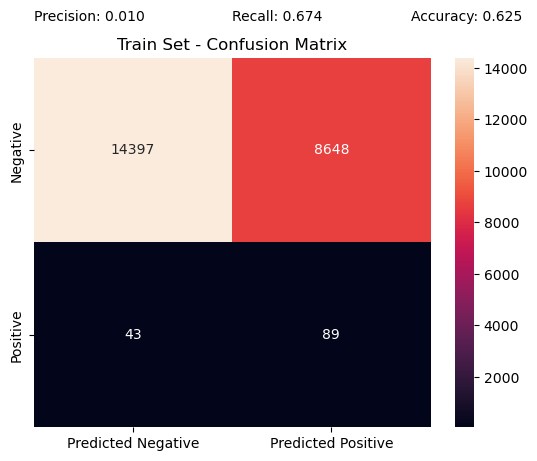

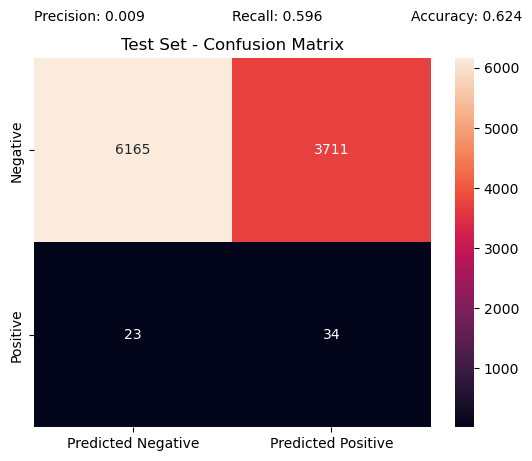

Training completed in 17.93 seconds


[SGDClassifier(loss='log_loss', penalty='l1', random_state=0)]

In [71]:
# L1 regularization
generate_SGD_classifier(X, y,
                        test_size = 0.3,
                        batch_sizes = [512],
                        sampler = 'RandomOverSampler',
                        sampling_strategy = 'not majority',
                        penalty = 'l1',
                        random_state = RANDOM_SEED,
                        model_name = "M2.5_SGD_OverSample_L1",
                        show_confusion_matrix = True)


### Stochastic Gradient Descent Classifier ###

Batch size: 512
Log loss at epoch 1 = 14.30	(best loss: 14.30)
Log loss at epoch 2 = 13.57	(best loss: 13.57)
Log loss at epoch 3 = 13.44	(best loss: 13.44)
Log loss at epoch 4 = 13.23	(best loss: 13.23)
Log loss at epoch 5 = 13.04	(best loss: 13.04)
Log loss at epoch 6 = 12.91	(best loss: 12.91)
Log loss at epoch 7 = 12.57	(best loss: 12.57)
Log loss at epoch 8 = 12.25	(best loss: 12.25)
Log loss at epoch 9 = 12.30	(best loss: 12.25)
Log loss at epoch 10 = 12.07	(best loss: 12.07)
Log loss at epoch 11 = 12.29	(best loss: 12.07)
Log loss at epoch 12 = 12.34	(best loss: 12.07)
Log loss at epoch 13 = 12.12	(best loss: 12.07)
Log loss at epoch 14 = 11.89	(best loss: 11.89)
Log loss at epoch 15 = 11.84	(best loss: 11.84)
Log loss at epoch 16 = 11.75	(best loss: 11.75)
Log loss at epoch 17 = 11.52	(best loss: 11.52)
Log loss at epoch 18 = 11.44	(best loss: 11.44)
Log loss at epoch 19 = 11.56	(best loss: 11.44)
Log loss at epoch 20 = 11.62	(be

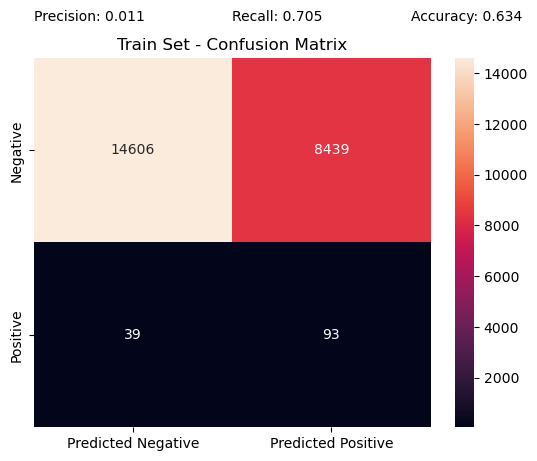

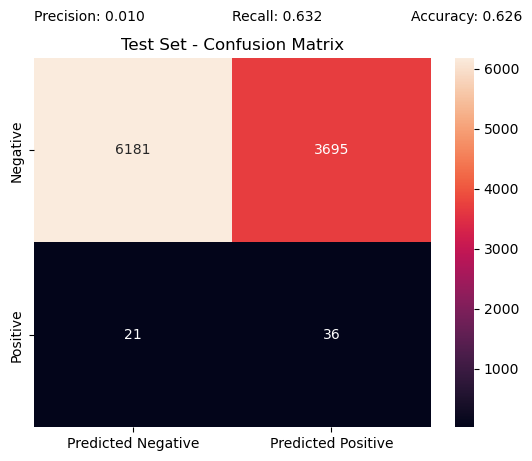

Training completed in 17.88 seconds


[SGDClassifier(loss='log_loss', penalty='elasticnet', random_state=0)]

In [72]:
# Elastic Net regularization
generate_SGD_classifier(X, y,
                        test_size = 0.3,
                        batch_sizes = [512],
                        sampler = 'RandomOverSampler',
                        sampling_strategy = 'not majority',
                        penalty = 'elasticnet',
                        random_state = RANDOM_SEED,
                        model_name = "M2.6_SGD_OverSample_EN",
                        show_confusion_matrix = True)

## Models Comparison

In [73]:
print("Train Models - Metrics Comparison")
round(df_metrics_train, 2)

Train Models - Metrics Comparison


,Model,Precision,Recall,Accuracy,F1,Log Loss
0,M0_LogRegr_Baseline,0.50,0.02,0.99,0.03,0.03
1,M1_LogRegr_ClassBalance,0.01,0.68,0.64,0.02,0.61
2,M2.1_SGD_FullBatch_BatchSize-23177,0.10,0.01,0.99,0.01,0.11
3,M2.2_SGD_FullBatch_UnderSample_BatchSize-264,0.01,0.59,0.52,0.01,12.70
4,M2.3_SGD_FullBatch_OverSample_BatchSize-46090,0.01,0.70,0.60,0.02,0.67
5,M2.4_SGD_OverSample_BatchSize-8,0.01,0.70,0.63,0.02,0.63
6,M2.4_SGD_OverSample_BatchSize-16,0.01,0.69,0.63,0.02,0.63
7,M2.4_SGD_OverSample_BatchSize-32,0.01,0.67,0.62,0.02,0.66
8,M2.4_SGD_OverSample_BatchSize-64,0.01,0.69,0.64,0.02,0.63
9,M2.4_SGD_OverSample_BatchSize-128,0.01,0.69,0.64,0.02,0.63


In [74]:
print("Train Models - Metrics Comparison")
round(df_metrics_test, 2)

Train Models - Metrics Comparison


,Model,Precision,Recall,Accuracy,F1,Log Loss
0,M0_LogRegr_Baseline,0.50,0.02,0.99,0.03,0.04
1,M1_LogRegr_ClassBalance,0.01,0.54,0.64,0.02,0.61
2,M2.1_SGD_FullBatch_BatchSize-23177,0.67,0.04,0.99,0.07,0.14
3,M2.2_SGD_FullBatch_UnderSample_BatchSize-264,0.01,0.47,0.52,0.01,12.64
4,M2.3_SGD_FullBatch_OverSample_BatchSize-46090,0.01,0.58,0.60,0.02,0.68
5,M2.4_SGD_OverSample_BatchSize-8,0.01,0.61,0.63,0.02,0.64
6,M2.4_SGD_OverSample_BatchSize-16,0.01,0.61,0.63,0.02,0.64
7,M2.4_SGD_OverSample_BatchSize-32,0.01,0.61,0.61,0.02,0.67
8,M2.4_SGD_OverSample_BatchSize-64,0.01,0.61,0.63,0.02,0.64
9,M2.4_SGD_OverSample_BatchSize-128,0.01,0.61,0.63,0.02,0.64


The model exploiting ElasticNet regularization has reached same performance of the oversampling model with batch size of 512, which uses default penalty L2.

## Model 3 - Naive Bayes Classifier

Given the observed overall low correlation between features in the correlation matrix, it seems beneficial to also test a Naive Bayes model, which is suitable when variables are assumed to be independent of each other.

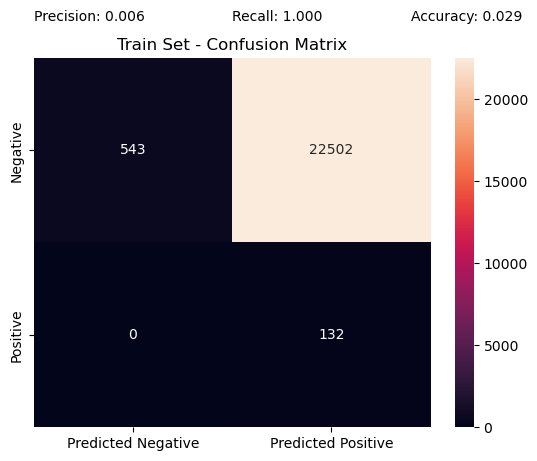

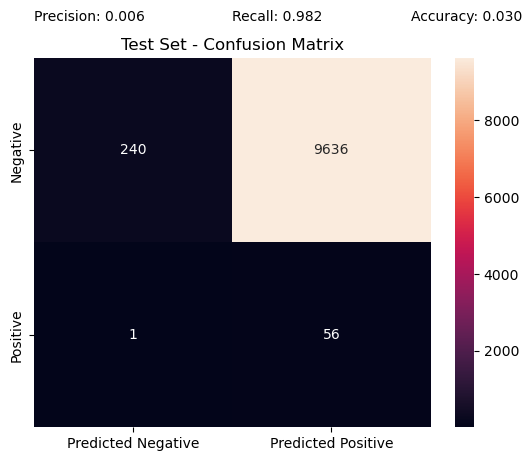

GaussianNB()

In [75]:
generate_naive_bayes_classifier(X, y,
                                test_size = 0.3,
                                model_selection = 'gaussian',
                                random_state = RANDOM_SEED,
                                model_name = 'M3.1_NB_Gaussian',
                                show_confusion_matrix = True)

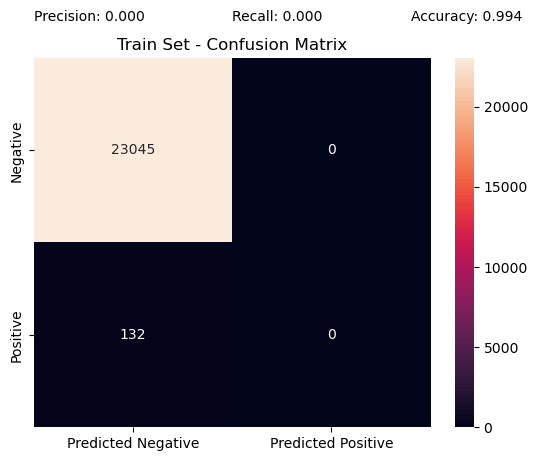

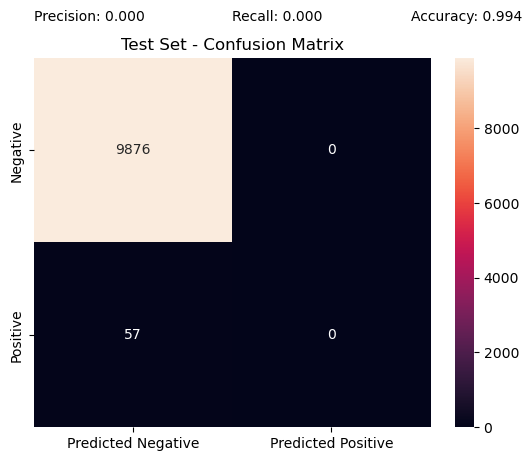

BernoulliNB()

In [76]:
generate_naive_bayes_classifier(X, y,
                                test_size = 0.3,
                                model_selection = 'bernoulli',
                                random_state = RANDOM_SEED,
                                model_name = 'M3.2_NB_Bernoulli',
                                show_confusion_matrix = True)

In [77]:
# NOT USABLE: error raised due to features with negative values
"""
generate_naive_bayes_classifier(X, y,
                                test_size = 0.3,
                                model_selection = 'multinomial',
                                random_state = RANDOM_SEED,
                                model_name = 'M3.3_NB_Multinomial',
                                show_confusion_matrix = True)
"""

"\ngenerate_naive_bayes_classifier(X, y,\n                                test_size = 0.3,\n                                model_selection = 'multinomial',\n                                random_state = RANDOM_SEED,\n                                model_name = 'M3.3_NB_Multinomial',\n                                show_confusion_matrix = True)\n"

In [78]:
# NOT USED
"""
generate_naive_bayes_classifier(X, y,
                                test_size = 0.3,
                                model_selection = 'complement',
                                random_state = RANDOM_SEED,
                                model_name = 'M3.4_NB_Complement',
                                show_confusion_matrix = True)
"""

"\ngenerate_naive_bayes_classifier(X, y,\n                                test_size = 0.3,\n                                model_selection = 'complement',\n                                random_state = RANDOM_SEED,\n                                model_name = 'M3.4_NB_Complement',\n                                show_confusion_matrix = True)\n"

In [79]:
# NOT USABLE: error raised due to features with negative values
"""
generate_naive_bayes_classifier(X, y,
                                test_size = 0.3,
                                model_selection = 'categorical',
                                random_state = RANDOM_SEED,
                                model_name = 'M3.5_NB_Categorical',
                                show_confusion_matrix = True)
"""

"\ngenerate_naive_bayes_classifier(X, y,\n                                test_size = 0.3,\n                                model_selection = 'categorical',\n                                random_state = RANDOM_SEED,\n                                model_name = 'M3.5_NB_Categorical',\n                                show_confusion_matrix = True)\n"

## Models Comparison

In [80]:
print("Train Models - Metrics Comparison")
round(df_metrics_train, 2)

Train Models - Metrics Comparison


,Model,Precision,Recall,Accuracy,F1,Log Loss
0,M0_LogRegr_Baseline,0.50,0.02,0.99,0.03,0.03
1,M1_LogRegr_ClassBalance,0.01,0.68,0.64,0.02,0.61
2,M2.1_SGD_FullBatch_BatchSize-23177,0.10,0.01,0.99,0.01,0.11
3,M2.2_SGD_FullBatch_UnderSample_BatchSize-264,0.01,0.59,0.52,0.01,12.70
4,M2.3_SGD_FullBatch_OverSample_BatchSize-46090,0.01,0.70,0.60,0.02,0.67
5,M2.4_SGD_OverSample_BatchSize-8,0.01,0.70,0.63,0.02,0.63
6,M2.4_SGD_OverSample_BatchSize-16,0.01,0.69,0.63,0.02,0.63
7,M2.4_SGD_OverSample_BatchSize-32,0.01,0.67,0.62,0.02,0.66
8,M2.4_SGD_OverSample_BatchSize-64,0.01,0.69,0.64,0.02,0.63
9,M2.4_SGD_OverSample_BatchSize-128,0.01,0.69,0.64,0.02,0.63


In [81]:
print("Train Models - Metrics Comparison")
round(df_metrics_test, 2)

Train Models - Metrics Comparison


,Model,Precision,Recall,Accuracy,F1,Log Loss
0,M0_LogRegr_Baseline,0.50,0.02,0.99,0.03,0.04
1,M1_LogRegr_ClassBalance,0.01,0.54,0.64,0.02,0.61
2,M2.1_SGD_FullBatch_BatchSize-23177,0.67,0.04,0.99,0.07,0.14
3,M2.2_SGD_FullBatch_UnderSample_BatchSize-264,0.01,0.47,0.52,0.01,12.64
4,M2.3_SGD_FullBatch_OverSample_BatchSize-46090,0.01,0.58,0.60,0.02,0.68
5,M2.4_SGD_OverSample_BatchSize-8,0.01,0.61,0.63,0.02,0.64
6,M2.4_SGD_OverSample_BatchSize-16,0.01,0.61,0.63,0.02,0.64
7,M2.4_SGD_OverSample_BatchSize-32,0.01,0.61,0.61,0.02,0.67
8,M2.4_SGD_OverSample_BatchSize-64,0.01,0.61,0.63,0.02,0.64
9,M2.4_SGD_OverSample_BatchSize-128,0.01,0.61,0.63,0.02,0.64


Looking at the poor metrics, especially accuracy for the first model and recall for the second model, it appears that Naive Bayes models may not be suitable to accurately classify the target variable in this context, since they tend to overestimate the positive classes.

## Model 4 - Support Vector Machine

Below, classification models based on Support Vector Machines will be implemented, since they are suitable for datasets with imbalanced classes and are capable of capturing non-linear relationships between features. Using the GridSearch function, the best combination of hyperparameters for the model is researched giving priority to recall ad accuracy metrics. Then the SVC model is selected and fitted based on best recall.

In [82]:
SVC_hyperparameters_table = {
    'kernel' : ['linear', 'poly', 'sigmoid', 'rbf'],
    'degree' : [2, 3, 4, 5],
    'class_weight' : ['balanced'],
    'C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
}
scoring_metric = ['recall', 'accuracy']
refit_metric = 'recall'

# Split the data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = RANDOM_SEED)

# Standardization
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

# SVC instance
svc = SVC(random_state = RANDOM_SEED)

# Starting time
tick = time()
    
# Evaluate best combination
grid_search = GridSearchCV(svc, SVC_hyperparameters_table, scoring = scoring_metric, refit = refit_metric, cv = 5, n_jobs = N_JOBS) # cross-validation with 5 folds
grid_search.fit(X_train, y_train)

# Show training time
print(f"Training completed in {time() - tick:.2f} seconds")

# Best combination
best_params_SVC = grid_search.best_params_

Training completed in 2234.84 seconds


In [83]:
# Best SVC parameters
best_params_SVC

{'C': 0.001, 'class_weight': 'balanced', 'degree': 2, 'kernel': 'sigmoid'}

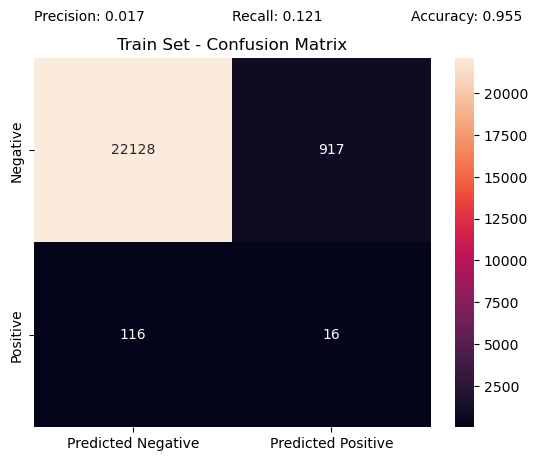

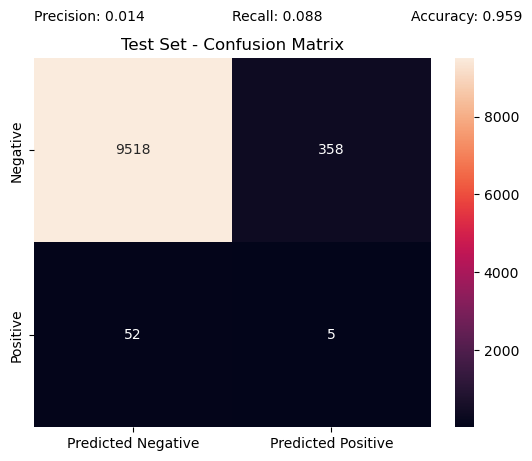

SVC(C=0.001, class_weight='balanced', degree=2, kernel='sigmoid',
    probability=True)

In [84]:
# Best SVM model
generate_SVM_classifier(X, y,
                        test_size = 0.3,
                        kernel = 'sigmoid',
                        weight = 'balanced',
                        C = 0.001,
                        degree = 2,
                        random_state = RANDOM_SEED,
                        model_name = "M4.1_SVC_sigmoid_balanced_degree-2_C-0.001",
                        show_confusion_matrix = True)

The model utilizing a sigmoid kernel and a strong regularization factor proves accurate in classifying the reliable customer class, but performs poorly in identifying unreliable customers, as evidenced by the very low recall value.

#### Polynomial Kernel

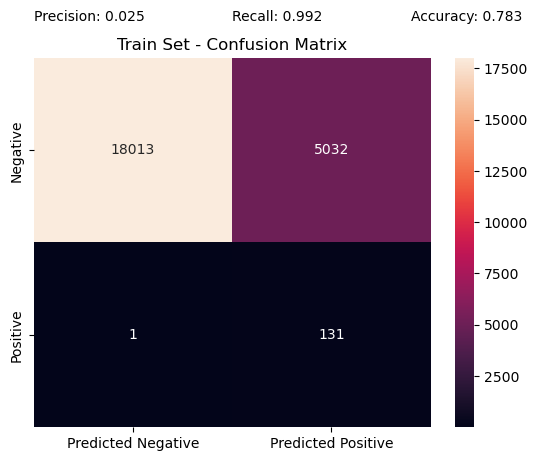

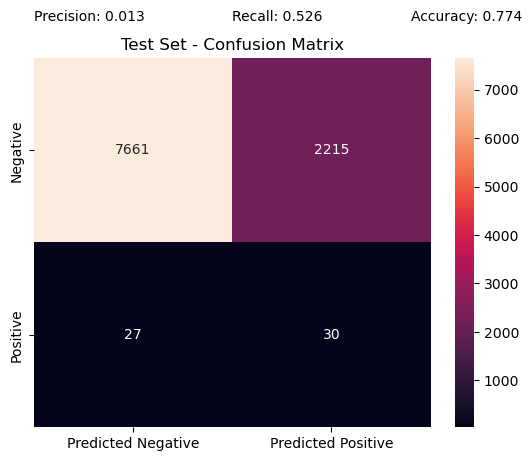

SVC(class_weight='balanced', degree=2, kernel='poly', probability=True)

In [85]:
generate_SVM_classifier(X, y,
                        test_size = 0.3,
                        kernel = 'poly',
                        weight = 'balanced',
                        degree = 2,
                        random_state = RANDOM_SEED,
                        model_name = "M4.2_SVC_poly_balanced_degree-2",
                        show_confusion_matrix = True)

#### Polynomial Kernel with Regularization

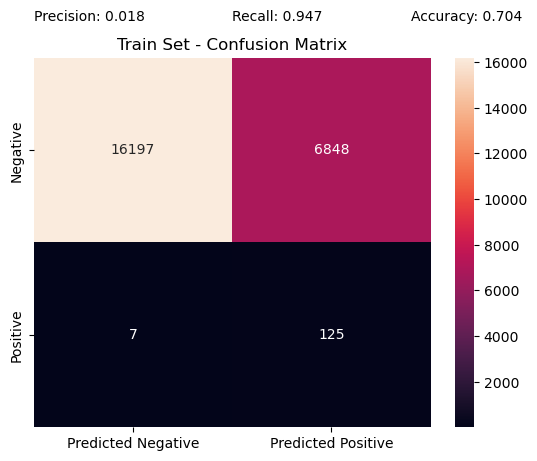

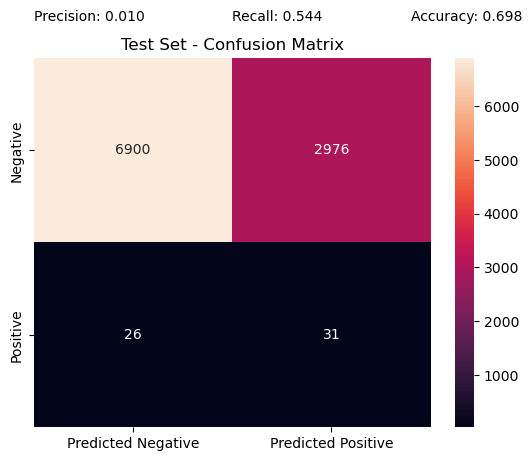

SVC(C=0.1, class_weight='balanced', degree=2, kernel='poly', probability=True)

In [86]:
generate_SVM_classifier(X, y,
                        test_size = 0.3,
                        kernel = 'poly',
                        weight = 'balanced',
                        degree = 2,
                        C = 0.1,
                        random_state = RANDOM_SEED,
                        model_name = "M4.3_SVC_poly_balanced_degree-2_C-0.1",
                        show_confusion_matrix = True)

#### RBF Kernel

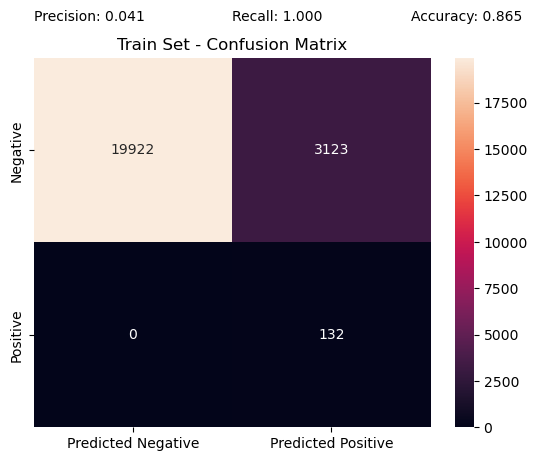

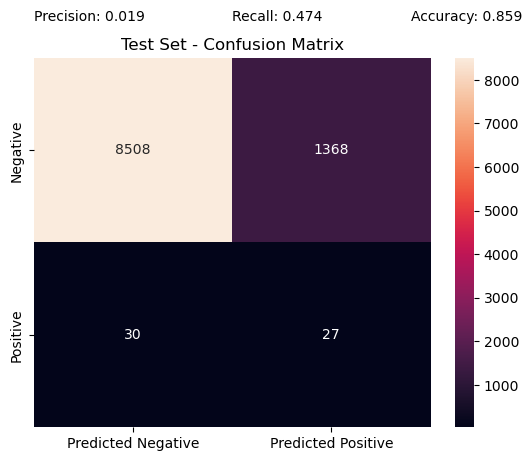

SVC(class_weight='balanced', probability=True)

In [87]:
generate_SVM_classifier(X, y,
                        test_size = 0.3,
                        kernel = 'rbf',
                        weight = 'balanced',
                        random_state = RANDOM_SEED,
                        model_name = "M4.4_SVC_rbf_balanced",
                        show_confusion_matrix = True)

#### RBF Kernel with Reduced Overfitting

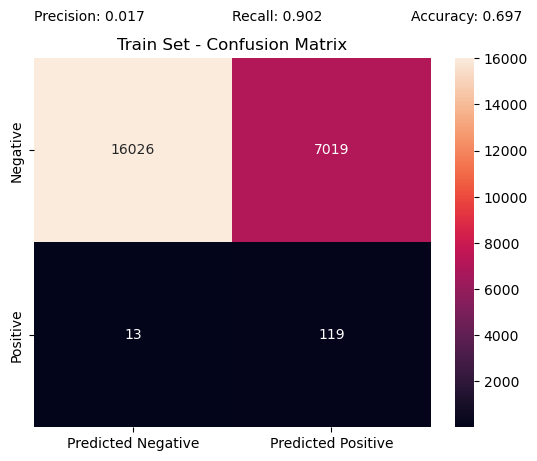

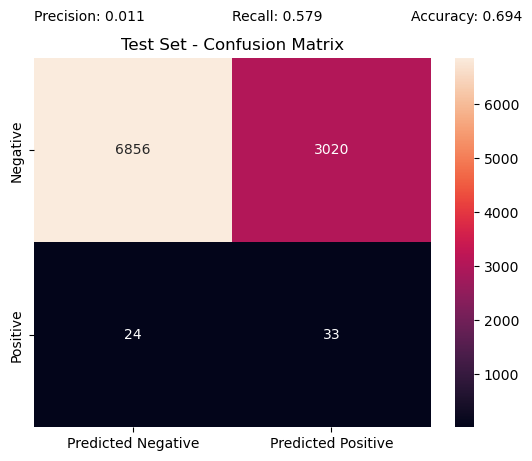

SVC(C=0.1, class_weight='balanced', gamma=0.01, probability=True)

In [88]:
generate_SVM_classifier(X, y,
                        test_size = 0.3,
                        kernel = 'rbf',
                        weight = 'balanced',
                        C = 0.1,
                        gamma = 0.01,
                        random_state = RANDOM_SEED,
                        model_name = "M4.5_SVC_rbf_balanced_refined",
                        show_confusion_matrix = True)

## Models Comparison

In [89]:
print("Train Models - Metrics Comparison")
round(df_metrics_train, 2)

Train Models - Metrics Comparison


,Model,Precision,Recall,Accuracy,F1,Log Loss
0,M0_LogRegr_Baseline,0.50,0.02,0.99,0.03,0.03
1,M1_LogRegr_ClassBalance,0.01,0.68,0.64,0.02,0.61
2,M2.1_SGD_FullBatch_BatchSize-23177,0.10,0.01,0.99,0.01,0.11
3,M2.2_SGD_FullBatch_UnderSample_BatchSize-264,0.01,0.59,0.52,0.01,12.70
4,M2.3_SGD_FullBatch_OverSample_BatchSize-46090,0.01,0.70,0.60,0.02,0.67
5,M2.4_SGD_OverSample_BatchSize-8,0.01,0.70,0.63,0.02,0.63
6,M2.4_SGD_OverSample_BatchSize-16,0.01,0.69,0.63,0.02,0.63
7,M2.4_SGD_OverSample_BatchSize-32,0.01,0.67,0.62,0.02,0.66
8,M2.4_SGD_OverSample_BatchSize-64,0.01,0.69,0.64,0.02,0.63
9,M2.4_SGD_OverSample_BatchSize-128,0.01,0.69,0.64,0.02,0.63


In [90]:
print("Train Models - Metrics Comparison")
round(df_metrics_test, 2)

Train Models - Metrics Comparison


,Model,Precision,Recall,Accuracy,F1,Log Loss
0,M0_LogRegr_Baseline,0.50,0.02,0.99,0.03,0.04
1,M1_LogRegr_ClassBalance,0.01,0.54,0.64,0.02,0.61
2,M2.1_SGD_FullBatch_BatchSize-23177,0.67,0.04,0.99,0.07,0.14
3,M2.2_SGD_FullBatch_UnderSample_BatchSize-264,0.01,0.47,0.52,0.01,12.64
4,M2.3_SGD_FullBatch_OverSample_BatchSize-46090,0.01,0.58,0.60,0.02,0.68
5,M2.4_SGD_OverSample_BatchSize-8,0.01,0.61,0.63,0.02,0.64
6,M2.4_SGD_OverSample_BatchSize-16,0.01,0.61,0.63,0.02,0.64
7,M2.4_SGD_OverSample_BatchSize-32,0.01,0.61,0.61,0.02,0.67
8,M2.4_SGD_OverSample_BatchSize-64,0.01,0.61,0.63,0.02,0.64
9,M2.4_SGD_OverSample_BatchSize-128,0.01,0.61,0.63,0.02,0.64


The SVC models have demonstrated not enough efficacy in achieving satisfactory classification performance for accurately predicting the target classes.

## Model 5 - Neural Network

Below a neural network model, precisely a Multi-Layer Perceptron, will be used in order to exploit its ability to understand complicated and non-linear patterns, adapting to different types of data and handling problems with intricate patterns.

In [91]:
MLP_hyperparameters_table = {
    'hidden_layer_sizes': [(50, 25), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200, 400, 800]
}
scoring_metric = ['recall', 'accuracy']
refit_metric = 'recall'

# Split the data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = RANDOM_SEED)

# Normalization
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

# MLP instance
mlp = MLPClassifier(random_state = RANDOM_SEED)

# Starting time
tick = time()
    
# Evaluate best combination
grid_search = GridSearchCV(mlp, MLP_hyperparameters_table, scoring = scoring_metric, refit = refit_metric, cv = 5, n_jobs = N_JOBS) # cross-validation with 5 folds
grid_search.fit(X_train, y_train)

# Show training time
print(f"Training completed in {time() - tick:.2f} seconds")

# Best combination
best_params_MLP = grid_search.best_params_

Training completed in 437.96 seconds


In [92]:
# Best MLP parameters
best_params_MLP

{'activation': 'tanh',
 'hidden_layer_sizes': (100, 100),
 'learning_rate': 'constant',
 'max_iter': 400,
 'solver': 'adam'}

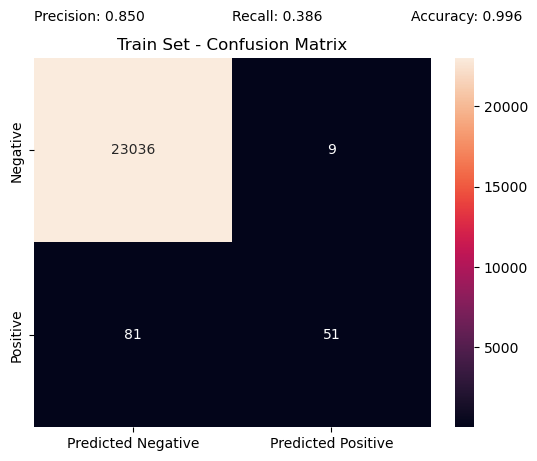

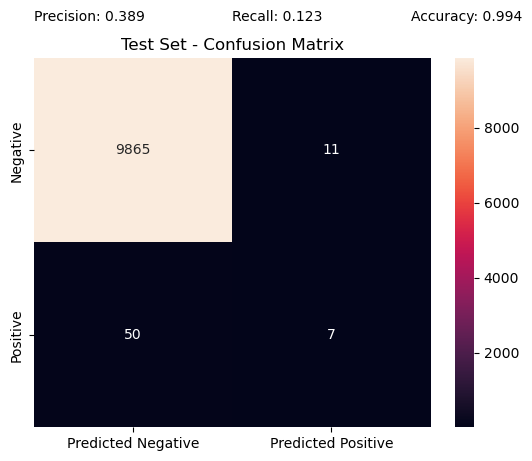

MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 100), max_iter=400,
              random_state=0)

In [93]:
# Best MLP generation
generate_MLP_classifier(X, y, test_size = 0.3,
                        hidden_layer_sizes = (100, 100),
                        activation = 'tanh',
                        learning_rate = 'constant',
                        solver = 'adam',
                        max_iter = 400,
                        random_state = RANDOM_SEED,
                        model_name = "M5.1_MLP_hls-100-100_tanh_constant_adam_iter-400",
                        show_confusion_matrix = True)

#### MLP with Relu Activation

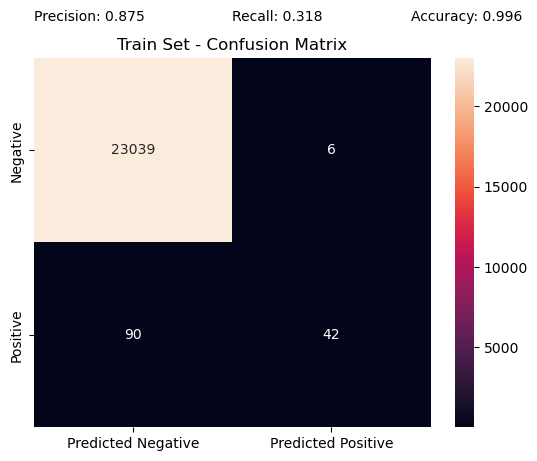

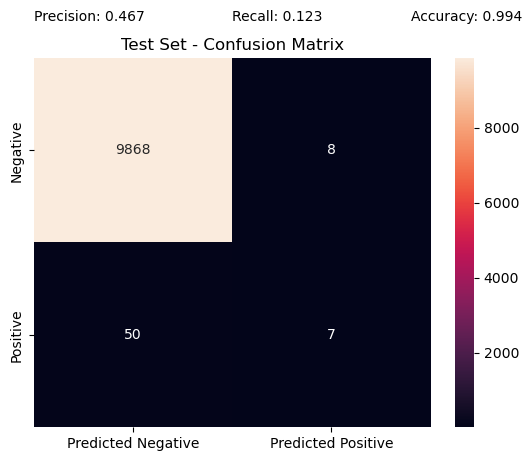

MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=400, random_state=0)

In [94]:
generate_MLP_classifier(X, y, test_size = 0.3,
                        hidden_layer_sizes = (100, 100),
                        activation = 'relu',
                        learning_rate = 'constant',
                        solver = 'adam',
                        max_iter = 400,
                        random_state = RANDOM_SEED,
                        model_name = "M5.2_MLP_hls-100-100_relu_constant_adam_iter-400",
                        show_confusion_matrix = True)

## Models Comparison

In [95]:
print("Train Models - Metrics Comparison")
round(df_metrics_train, 2)

Train Models - Metrics Comparison


,Model,Precision,Recall,Accuracy,F1,Log Loss
0,M0_LogRegr_Baseline,0.50,0.02,0.99,0.03,0.03
1,M1_LogRegr_ClassBalance,0.01,0.68,0.64,0.02,0.61
2,M2.1_SGD_FullBatch_BatchSize-23177,0.10,0.01,0.99,0.01,0.11
3,M2.2_SGD_FullBatch_UnderSample_BatchSize-264,0.01,0.59,0.52,0.01,12.70
4,M2.3_SGD_FullBatch_OverSample_BatchSize-46090,0.01,0.70,0.60,0.02,0.67
5,M2.4_SGD_OverSample_BatchSize-8,0.01,0.70,0.63,0.02,0.63
6,M2.4_SGD_OverSample_BatchSize-16,0.01,0.69,0.63,0.02,0.63
7,M2.4_SGD_OverSample_BatchSize-32,0.01,0.67,0.62,0.02,0.66
8,M2.4_SGD_OverSample_BatchSize-64,0.01,0.69,0.64,0.02,0.63
9,M2.4_SGD_OverSample_BatchSize-128,0.01,0.69,0.64,0.02,0.63


In [96]:
print("Train Models - Metrics Comparison")
round(df_metrics_test, 2)

Train Models - Metrics Comparison


,Model,Precision,Recall,Accuracy,F1,Log Loss
0,M0_LogRegr_Baseline,0.50,0.02,0.99,0.03,0.04
1,M1_LogRegr_ClassBalance,0.01,0.54,0.64,0.02,0.61
2,M2.1_SGD_FullBatch_BatchSize-23177,0.67,0.04,0.99,0.07,0.14
3,M2.2_SGD_FullBatch_UnderSample_BatchSize-264,0.01,0.47,0.52,0.01,12.64
4,M2.3_SGD_FullBatch_OverSample_BatchSize-46090,0.01,0.58,0.60,0.02,0.68
5,M2.4_SGD_OverSample_BatchSize-8,0.01,0.61,0.63,0.02,0.64
6,M2.4_SGD_OverSample_BatchSize-16,0.01,0.61,0.63,0.02,0.64
7,M2.4_SGD_OverSample_BatchSize-32,0.01,0.61,0.61,0.02,0.67
8,M2.4_SGD_OverSample_BatchSize-64,0.01,0.61,0.63,0.02,0.64
9,M2.4_SGD_OverSample_BatchSize-128,0.01,0.61,0.63,0.02,0.64


The utilization of a neural network also proves ineffective in terms of achieving a high recall for the target class.

## Model 6 - Nearest Neighbors

Two additional models, K-Nearest Neighbor and Radius-Nearest Neighbor algorithms, will be employed to identify similarities with existing instances in the dataset based on proximity in the feature space.

In [97]:
KNN_hyperparameters_table = {
    'n_neighbors': [1, 2, 3, 4, 5, 10, 20, 30, 40, 50],
    'weights': ['uniform', 'distance'],
}
scoring_metric = ['recall', 'accuracy']
refit_metric = 'recall'

# Split the data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = RANDOM_SEED)

# Normalization
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

# MLP instance
knn = KNeighborsClassifier()

# Starting time
tick = time()
    
# Evaluate best combination
grid_search = GridSearchCV(knn, KNN_hyperparameters_table, scoring = scoring_metric, refit = refit_metric, cv = 5, n_jobs = N_JOBS) # cross-validation with 5 folds
grid_search.fit(X_train, y_train)

# Show training time
print(f"Training completed in {time() - tick:.2f} seconds")

# Best combination
best_params_KNN = grid_search.best_params_

Training completed in 4.54 seconds


In [98]:
# Best KNN parameters
best_params_KNN

{'n_neighbors': 1, 'weights': 'uniform'}

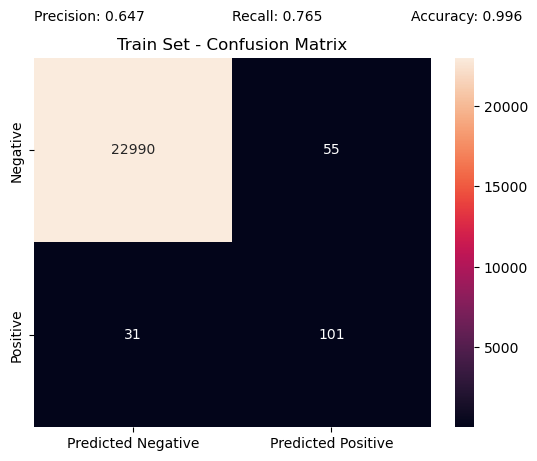

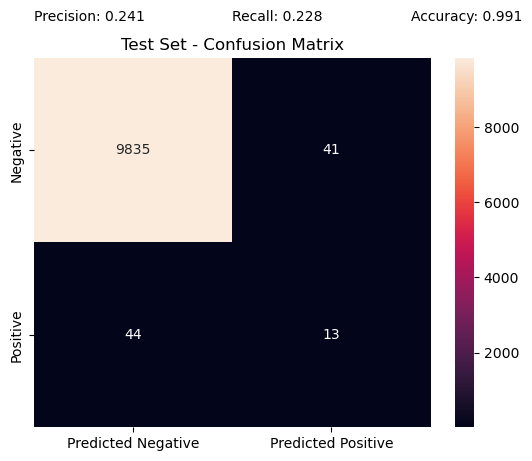

KNeighborsClassifier(n_neighbors=1)

In [99]:
# Best KNN model generation
generate_neighbors_classifier(X, y, test_size = 0.3,
                       model_selection = 'KNN',
                       n_neighbors = 1,
                       weights = 'uniform',
                       random_state = RANDOM_SEED,
                       model_name = "M6.1_KNN_neighbor-1_weights-uniform",
                       show_confusion_matrix = True)

In [100]:
RNN_hyperparameters_table = {
    'radius': [1, 2, 3, 4 ,5, 10],
    'weights': ['uniform', 'distance'],
}
scoring_metric = ['recall', 'accuracy']
refit_metric = 'recall'

# Split the data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = RANDOM_SEED)

# Normalization
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

# MLP instance
rnn = RadiusNeighborsClassifier()

# Starting time
tick = time()
    
# Evaluate best combination
grid_search = GridSearchCV(rnn, RNN_hyperparameters_table, scoring = scoring_metric, refit = refit_metric, cv = 5, n_jobs = N_JOBS) # cross-validation with 5 folds
grid_search.fit(X_train, y_train)

# Show training time
print(f"Training completed in {time() - tick:.2f} seconds")

# Best combination
best_params_RNN = grid_search.best_params_

Training completed in 67.89 seconds


One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.         0.14358974
 0.         0.14358974 0.         0.14358974 0.         0.14358974]
One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.99430471 0.99352796
 0.99430471 0.99352796 0.99430471 0.99352796 0.99430471 0.99352796]


In [101]:
# Best RNN parameters
best_params_RNN

{'radius': 3, 'weights': 'distance'}

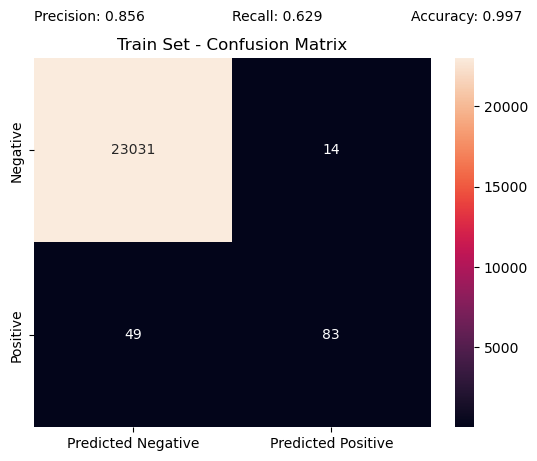

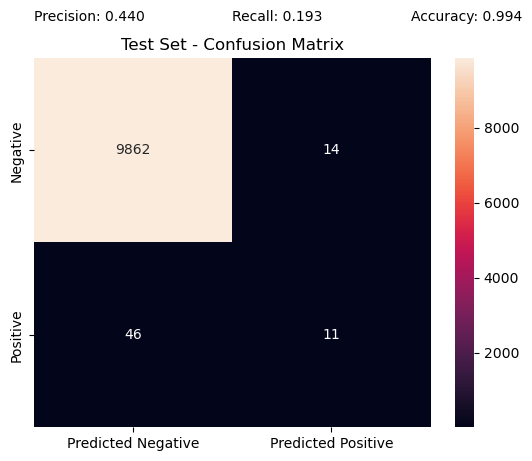

RadiusNeighborsClassifier(radius=3, weights='distance')

In [102]:
# Best RNN model generation
generate_neighbors_classifier(X, y, test_size = 0.3,
                       model_selection = 'RNN',
                       radius = 3,
                       weights = 'distance',
                       random_state = RANDOM_SEED,
                       model_name = "M6.2_RNN_radius-3_weights-distance",
                       show_confusion_matrix = True)

## Models Comparison

In [103]:
print("Train Models - Metrics Comparison")
round(df_metrics_train, 2)

Train Models - Metrics Comparison


,Model,Precision,Recall,Accuracy,F1,Log Loss
0,M0_LogRegr_Baseline,0.50,0.02,0.99,0.03,0.03
1,M1_LogRegr_ClassBalance,0.01,0.68,0.64,0.02,0.61
2,M2.1_SGD_FullBatch_BatchSize-23177,0.10,0.01,0.99,0.01,0.11
3,M2.2_SGD_FullBatch_UnderSample_BatchSize-264,0.01,0.59,0.52,0.01,12.70
4,M2.3_SGD_FullBatch_OverSample_BatchSize-46090,0.01,0.70,0.60,0.02,0.67
5,M2.4_SGD_OverSample_BatchSize-8,0.01,0.70,0.63,0.02,0.63
6,M2.4_SGD_OverSample_BatchSize-16,0.01,0.69,0.63,0.02,0.63
7,M2.4_SGD_OverSample_BatchSize-32,0.01,0.67,0.62,0.02,0.66
8,M2.4_SGD_OverSample_BatchSize-64,0.01,0.69,0.64,0.02,0.63
9,M2.4_SGD_OverSample_BatchSize-128,0.01,0.69,0.64,0.02,0.63


In [104]:
print("Train Models - Metrics Comparison")
round(df_metrics_test, 2)

Train Models - Metrics Comparison


,Model,Precision,Recall,Accuracy,F1,Log Loss
0,M0_LogRegr_Baseline,0.50,0.02,0.99,0.03,0.04
1,M1_LogRegr_ClassBalance,0.01,0.54,0.64,0.02,0.61
2,M2.1_SGD_FullBatch_BatchSize-23177,0.67,0.04,0.99,0.07,0.14
3,M2.2_SGD_FullBatch_UnderSample_BatchSize-264,0.01,0.47,0.52,0.01,12.64
4,M2.3_SGD_FullBatch_OverSample_BatchSize-46090,0.01,0.58,0.60,0.02,0.68
5,M2.4_SGD_OverSample_BatchSize-8,0.01,0.61,0.63,0.02,0.64
6,M2.4_SGD_OverSample_BatchSize-16,0.01,0.61,0.63,0.02,0.64
7,M2.4_SGD_OverSample_BatchSize-32,0.01,0.61,0.61,0.02,0.67
8,M2.4_SGD_OverSample_BatchSize-64,0.01,0.61,0.63,0.02,0.64
9,M2.4_SGD_OverSample_BatchSize-128,0.01,0.61,0.63,0.02,0.64


Both Nearest Neighbor models appear inadequate for appropriately classifying the data, and both seem to suffer from overfitting.

## Model Selection

To select the best model among those generated, since the focus is on recall and accuracy, the harmonic mean between these metrics is calculated and then the best model is chosen.

In [113]:
# Harmonic mean
df_metrics_test_score = df_metrics_test.copy()
df_metrics_test_score['Score'] = (df_metrics_test['Recall']*df_metrics_test['Accuracy'])/(df_metrics_test['Recall'] + df_metrics_test['Accuracy'])

In [117]:
# Best 3 models
top_models = round(df_metrics_test_score.nlargest(3, 'Score'), 2)

In [118]:
top_models

,Model,Precision,Recall,Accuracy,F1,Log Loss,Score
20,M4.5_SVC_rbf_balanced_refined,0.01,0.58,0.69,0.02,0.03,0.32
13,M2.6_SGD_OverSample_EN_BatchSize-512,0.01,0.63,0.63,0.02,0.65,0.31
11,M2.4_SGD_OverSample_BatchSize-512,0.01,0.63,0.63,0.02,0.65,0.31


## Explainability

Designating "M4.5_SVC_rbf_balanced_refined" as the best obtained model, also given its lower log loss compared to others, the training is rerun to assess which features have the greatest impact on the class prediction. This is done using the SHAP (SHapley Additive exPlanations) framework.

In [108]:
# Split the data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = RANDOM_SEED)

# Standardization
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

# Oversampling
ros = RandomOverSampler(sampling_strategy = 'not majority', random_state = RANDOM_SEED)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Initializations
batch_size = 512
epochs = 200
tolerance = 0.0001
n_iter_count = 0
n_iter_no_change = 10
best_loss = float("inf")

# Classes list
classes = np.unique(y_train)

# Set batches number
n_batches = int(X_resampled.shape[0]//batch_size)    

# SGD classifier instance
sgd = SGDClassifier(loss = 'log_loss', random_state = RANDOM_SEED)

# For each epoch...
for epoch in range(epochs):

    # ...the dataset is shuffled
    X_shuffled, y_shuffled = shuffle(X_resampled, y_resampled, random_state = RANDOM_SEED)             

    # Cycle all batches 
    for batch in range(n_batches):

        # First observation for current batch
        batch_start = int(batch*batch_size)

        # Last observation for current batch
        batch_end = int((batch + 1)*batch_size)

        # Current batch selection
        X_batch = X_shuffled[batch_start:batch_end, :]
        y_batch = y_shuffled[batch_start:batch_end]

        # Model partially trained with the current batch, ensuring awareness of all classes                
        sgd.partial_fit(X_batch, y_batch, classes = classes)

        # Log loss evaluation
        loss = log_loss(y_resampled, sgd.predict(X_resampled), labels = classes)                   

    # Early stopping condition
    if loss >= best_loss - tolerance:
        if n_iter_count >= n_iter_no_change:
            break
        else:
            n_iter_count += 1
    else:
        best_loss = loss
        n_iter_count = 0

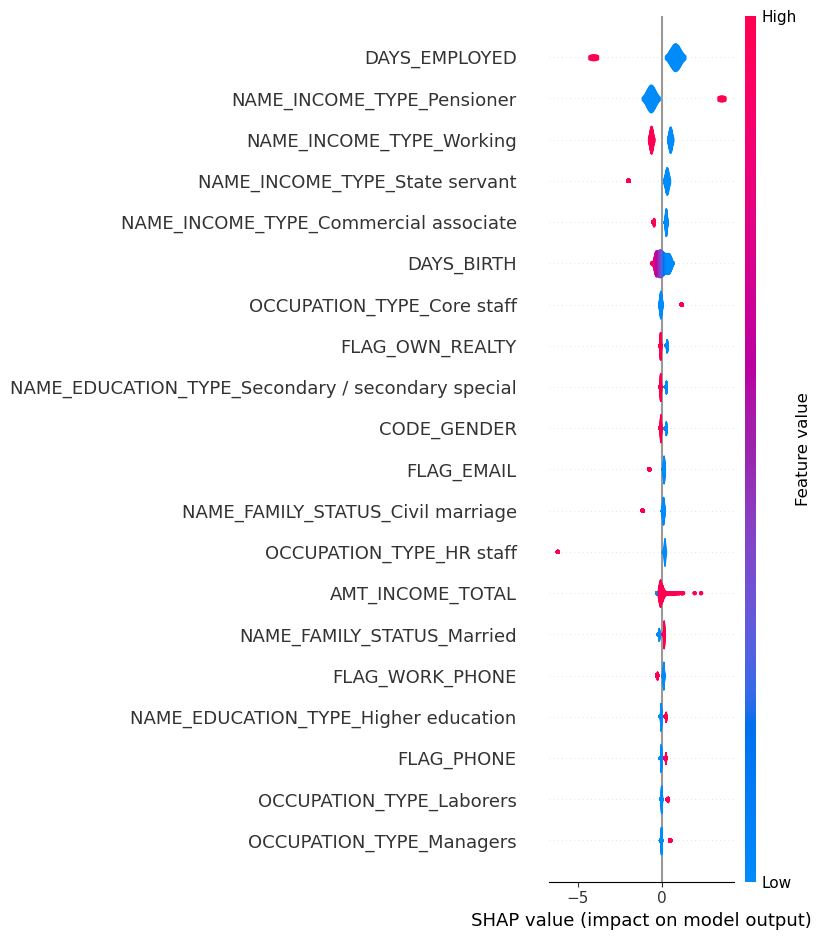

In [109]:
# Summarize the background dataset using 1000 samples
background_summary = shap.sample(X_train, 1000)

# Create a SHAP Explainer object with the summarized background dataset
explainer = shap.Explainer(sgd, background_summary)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test)

# Visualize a SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type = 'violin', feature_names = df_preproc.drop('RELIABILITY', axis = 1).columns)

From the SHAP values, it is evident that DAYS_EMPLOYED has the greatest impact in determining the customer's reliability class. For a customer with higher values of DAYS_EMPLOYED, indicating being employed for fewer days or currently unemployed, this feature contributes to classifying them as reliable. Additionally, it is observed that income from pension contributes positively to classifying the customer as unreliable.

As customers in pension have set a positive placeholder value of DAYS_EMPLOYED equal to 365243, simulating indefinite unemployment period, it is inferred that DAYS_EMPLOYED and NAME_INCOME_TYPE_Pensioner provide seemingly contradictory contributions to the model's classification. This point indicates how the relationship for classification can be highly complex and determined by other factors from different features.

## Conclusions

The best model obtained for datasets analysis is considered to be of mediocre performance. A recall value of 0.63 and a similar accuracy value do not allow for sufficient differentiation between reliable and unreliable customers, given the presence of both many false negatives and false positives.
Possible solutions to achieve a better model performance could include:
- **Target Optimization**: Since the target was not explicitly provided but artificially created from information regarding the payment history for some customers, it is possible that with better domain knowledge in the banking sector, the reliability class could be engineered more appropriately.
- **Overfitting Reduction**: Many models exhibited significantly better performance on training data compared to test data, indicating overfitting. By using improved regularization techniques and features selection, it might be possible to achieve a better balance between bias and variance, resulting in improved metrics.
- **Quantity and Quality of Data**: Certainly, updating the models with additional data would be optimal to address the highly skewed nature of the target class. Regarding data quality, it would be desirable to correct information related to the large portion of missing data for OCCUPATION_TYPE or manage the placeholder used for DAYS_EMPLOYED for pensioner clients more effectively (for example, imputing the client's age would be less implausible than setting 365,243 days, namely 1000 years).